In [2]:
from overcooked_ai_py.utils import load_pickle, mean_and_std_err
import copy
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib import cm

# TODO: Uncomment out these 5 lines (if not uncommented already)
# from human_aware_rl.data_dir import DATA_DIR
# from human_ai_robustness.common import *
# set_style(tex=False)
# from human_ai_robustness.qualitative_robustness_expt import filter_tests_by_attribute, AbstractRobustnessTest
# ALL_TEST_TYPES = AbstractRobustnessTest.ALL_TEST_TYPES

In [3]:
#TODO: Hacky fix by paul:
DATA_DIR = '/home/pmzpk/Dropbox/Pycharm_paulk444/human_ai_robustness/human_ai_robustness/data/'

In [5]:
# TODO: comment out this cell (if not commented out already), and uncomment the lines above
# For some reason I'm having problems with import statements of `human_ai_robustness` on jupyter notebooks locally

ALL_TEST_TYPES = ["state_robustness", "agent_robustness", "agent_robustness_plus_memory", "reward"]

def filter_tests_by_attribute(tests_dict, attribute, value):
    """
    Returns tests that have `attribute` == `value`
    """
    filtered_tests = {}
    for test_name, test_data_dict in tests_dict.items():
        if test_data_dict[attribute] == value:
            filtered_tests[test_name] = test_data_dict
    return filtered_tests

def set_style(font_scale=1.6, tex=True):
    import seaborn, matplotlib
    seaborn.set(font='serif', font_scale=font_scale)
    # Make the background white, and specify the specific font family
    seaborn.set_style("white", {
        "font.family": "serif",
        "font.weight": "normal",
        "font.serif": ["Times", "Palatino", "serif"],
        'axes.facecolor': 'white',
        'lines.markeredgewidth': 1})
    matplotlib.rcParams['text.usetex'] = tex
    matplotlib.rc('font',family='serif', serif=['Palatino'])

set_style(tex=False)


In [6]:
def average_across_tests(tests_dict, avg_name):
    """
    Takes in a PER-LAYOUT data format dict and outputs a dict with
    average success rate (currenlty doesn't do ses).
    """
#     if tests_dict == {}:
#         return {}
    
    averaged_test = defaultdict(dict)
    tests_layout = list(tests_dict.values())[0]['layout']
    assert all(test['layout'] == tests_layout for test in tests_dict.values())
    averaged_test_dict = {}
    # We want to see what the average test score for this type of test (e.g. agent_robustness) is
    # across seeds, and take the SE w.r.t. to that
    averaged_test_dict["success_rate_across_seeds"] = np.mean(
        [test["success_rate_across_seeds"] for test in tests_dict.values()], axis=0
    )
    averaged_test_dict["layout"] = tests_layout
    return averaged_test_dict

def average_across_different_test_types(tests_dict, test_types=ALL_TEST_TYPES):
    """
    Takes in a PER-LAYOUT data format dict and outputs a PER-LAYOUT data
    format dict in which all the tests are replaced with the test types in
    ALL_TEST_TYPES, and the success rates are averaged across the different
    tests that compose them
    """
    new_tests_dict = defaultdict(lambda: defaultdict(dict))
    for agent_name, agent_data in tests_dict.items():
        for test_type in test_types:
#             print("Averaging tests with test type {} for agent {}".format(test_type, agent_name))
            filtered_tests_dict = filter_tests_by_attribute(agent_data, "test_types", [test_type])
            if filtered_tests_dict == {}:
                continue
            new_tests_dict[agent_name][test_type] = average_across_tests(filtered_tests_dict, test_type)
    return new_tests_dict

def filter_all_tests_by_attribute(all_test_data, attribute, value):
    return { agent_name : filter_tests_by_attribute(test_dict, attribute, value) for agent_name, test_dict in all_test_data.items() }

def hatch_fn(name):
    if "ns" in name:
        return "/"

def simple_layout_histogram(results_dicts, ax=None, fig=None, barWidth=0.2, add_label=True, figsize=(20, 10), color_fn=None, key_ordering=None, gaps=[], col_size=20):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    layout = list(list(results_dicts.values())[0].values())[0]['layout']
    
    success_means_by_agent = defaultdict(list)
    success_ses_by_agent = defaultdict(list)

    for agent_type, result_dict in results_dicts.items():
        for test_name, test_data in result_dict.items():
            assert layout == test_data["layout"], "All in same results sub-dict should be from the same layout"
            success_mean, success_se = mean_and_std_err(test_data["success_rate_across_seeds"])
            success_means_by_agent[agent_type].append(success_mean)
            success_ses_by_agent[agent_type].append(success_se)
    
    x_axis = [k for k, v in list(results_dicts.values())[0].items() if v['layout'] == layout]
    xs = list(range(len(x_axis)))
    
    viridis_cols = cm.get_cmap('tab20c', col_size)#len(results_dicts.keys()))
    
    if key_ordering is not None:
        key_ordering = [k for k in key_ordering if k in results_dicts.keys()]
        assert sorted(key_ordering) == sorted(list(results_dicts.keys()))
    else:
        key_ordering = list(results_dicts.keys())

    for i, k in enumerate(key_ordering):
        if i in gaps:
            xs = np.array(xs) + barWidth / 2
        xs = np.array(xs) + barWidth
        ys = success_means_by_agent[k]
        yerrs = success_ses_by_agent[k]
        label = k if add_label else None
        ax.bar(xs, ys, yerr=yerrs, width=barWidth, label=label, hatch=hatch_fn(k), color=colors_fn(k) if color_fn is not None else viridis_cols.colors[i])
    ax.set_title("qualitative experiments across models for layout {}".format(layout))
    ax.set_ylabel("success rate")
    ax.set_xticks([r + barWidth for r in range(len(xs))])
    ax.set_xticklabels(x_axis)
    ax.grid()
    fig.legend()

def get_num_cols_and_rows(num_layouts):
    if num_layouts in [1, 2, 3]:
        ncols = num_layouts
        nrows = 1
    elif num_layouts == 4:
        ncols = 2
        nrows = 2
    elif num_layouts == 6:
        ncols = 3
        nrows = 2
    else:
        raise ValueError("Not supported number of layouts")
    return ncols, nrows

def multi_plot_histograms(across_layout_results_dicts, layouts, barWidth=0.2, figsize=None, key_ordering=None, gaps=[], col_size=20):            
    # NOTE: In this function I plot many simple_plots, with all tests, but one can easily
    # chain preprocessing functions to have multi_plot_histograms for other types of graphs too
    
    ncols, nrows = get_num_cols_and_rows(len(layouts))
        
    if figsize is None:
        # Simple heuristic for recommended graph size
        figsize = (20 * ncols, 10 * nrows)
    
    fig, axes = plt.subplots(figsize=figsize, ncols=ncols, nrows=nrows)
    
    for graph_idx, (layout, ax) in enumerate(zip(layouts, np.ravel(axes))):
#         print(graph_idx)
        add_label = graph_idx == 0
        simple_layout_histogram(across_layout_results_dicts[layout], ax=ax, fig=fig, barWidth=barWidth, add_label=add_label, key_ordering=key_ordering, gaps=gaps, col_size=col_size)
    

def colors_fn(agent_name):
    if agent_name == "agent_0":
        return "red"
    elif agent_name == "agent_1":
        return "blue"
    else:
        return "gray"
#         raise ValueError("Unrecognized agent type {}. Must define a custom color for this agent type".format(agent_name))

In [267]:
# You load results for each agent that you've evaluated independently, and just have to specify the agent's name
sample_data_path = DATA_DIR + "qualitative_expts/results_cring_1bc_ns.pickle"
results_a = load_pickle(sample_data_path)
results_b = load_pickle(sample_data_path)

# PER-LAYOUT data format
# Standard data format per-layout! Currently assuming that all results in dict are for one specific layout.
results_cring = {
    # Agent name    # Agent results dict as saved by script
    "agent_0":      results_a,
    "agent_1":      results_b
}

# ACROSS-LAYOUT data format
# Standard data format across-layout
results_bottleneck = None
results_across_layouts = {
    "bottleneck": results_bottleneck,
    "coordination_ring": results_cring
}

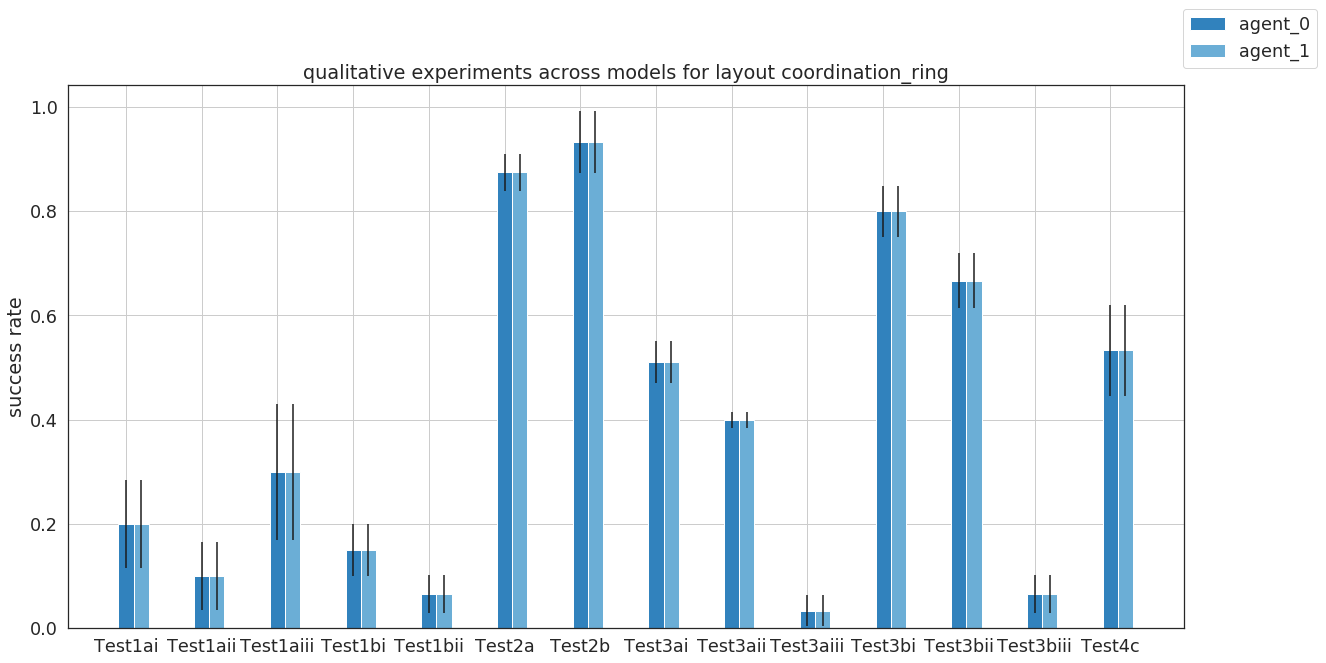

In [258]:
# Then you can plot a graph for each layout separately which compares the agents
simple_layout_histogram(results_cring)

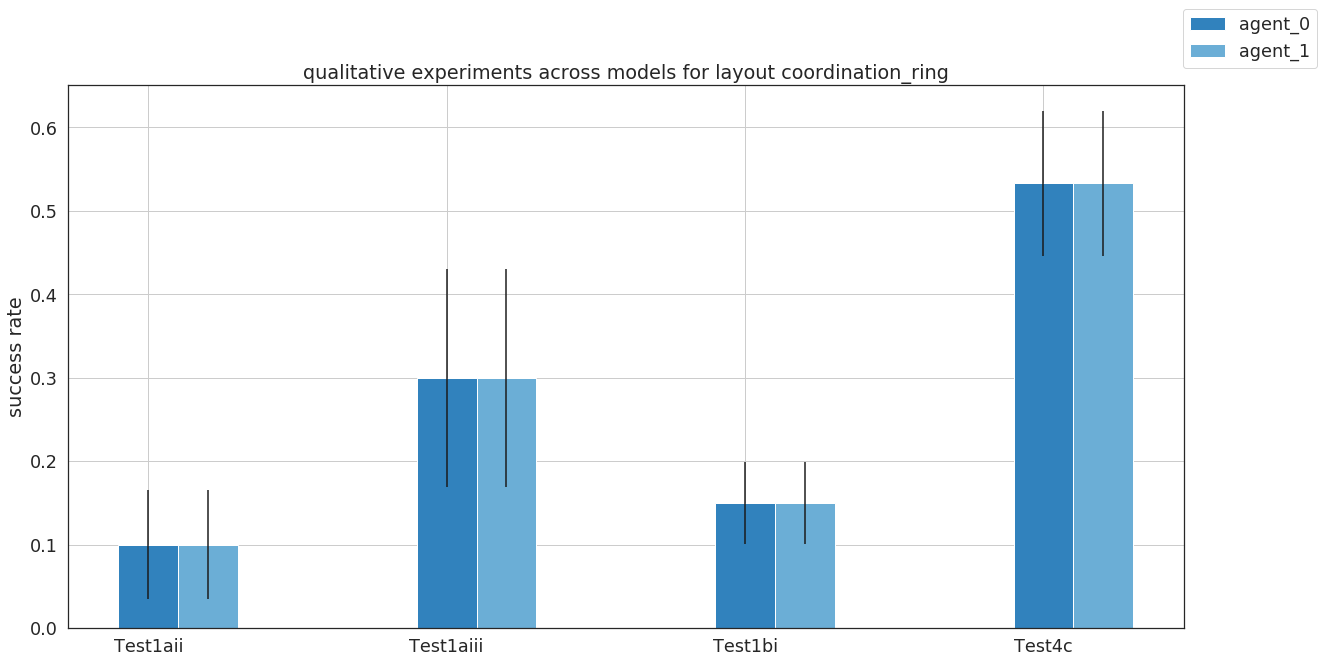

In [259]:
# You can do this after filtering for a certain test type, but still having the split by test
results_filtered = filter_all_tests_by_attribute(results_cring, "test_types", ["state_robustness"])
simple_layout_histogram(results_filtered)

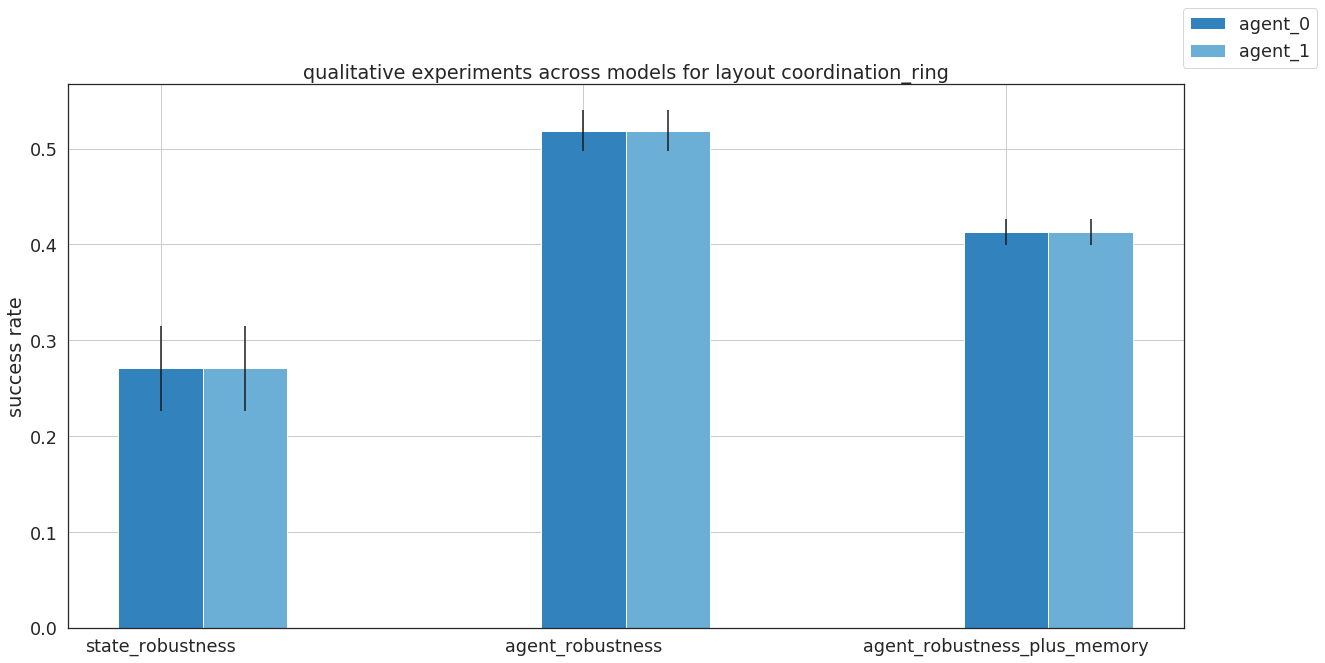

In [260]:
# Or average across all tests of a certain kind, and plot all results on one graph
averaged_by_test_type_results = average_across_different_test_types(results_cring)
simple_layout_histogram(averaged_by_test_type_results)

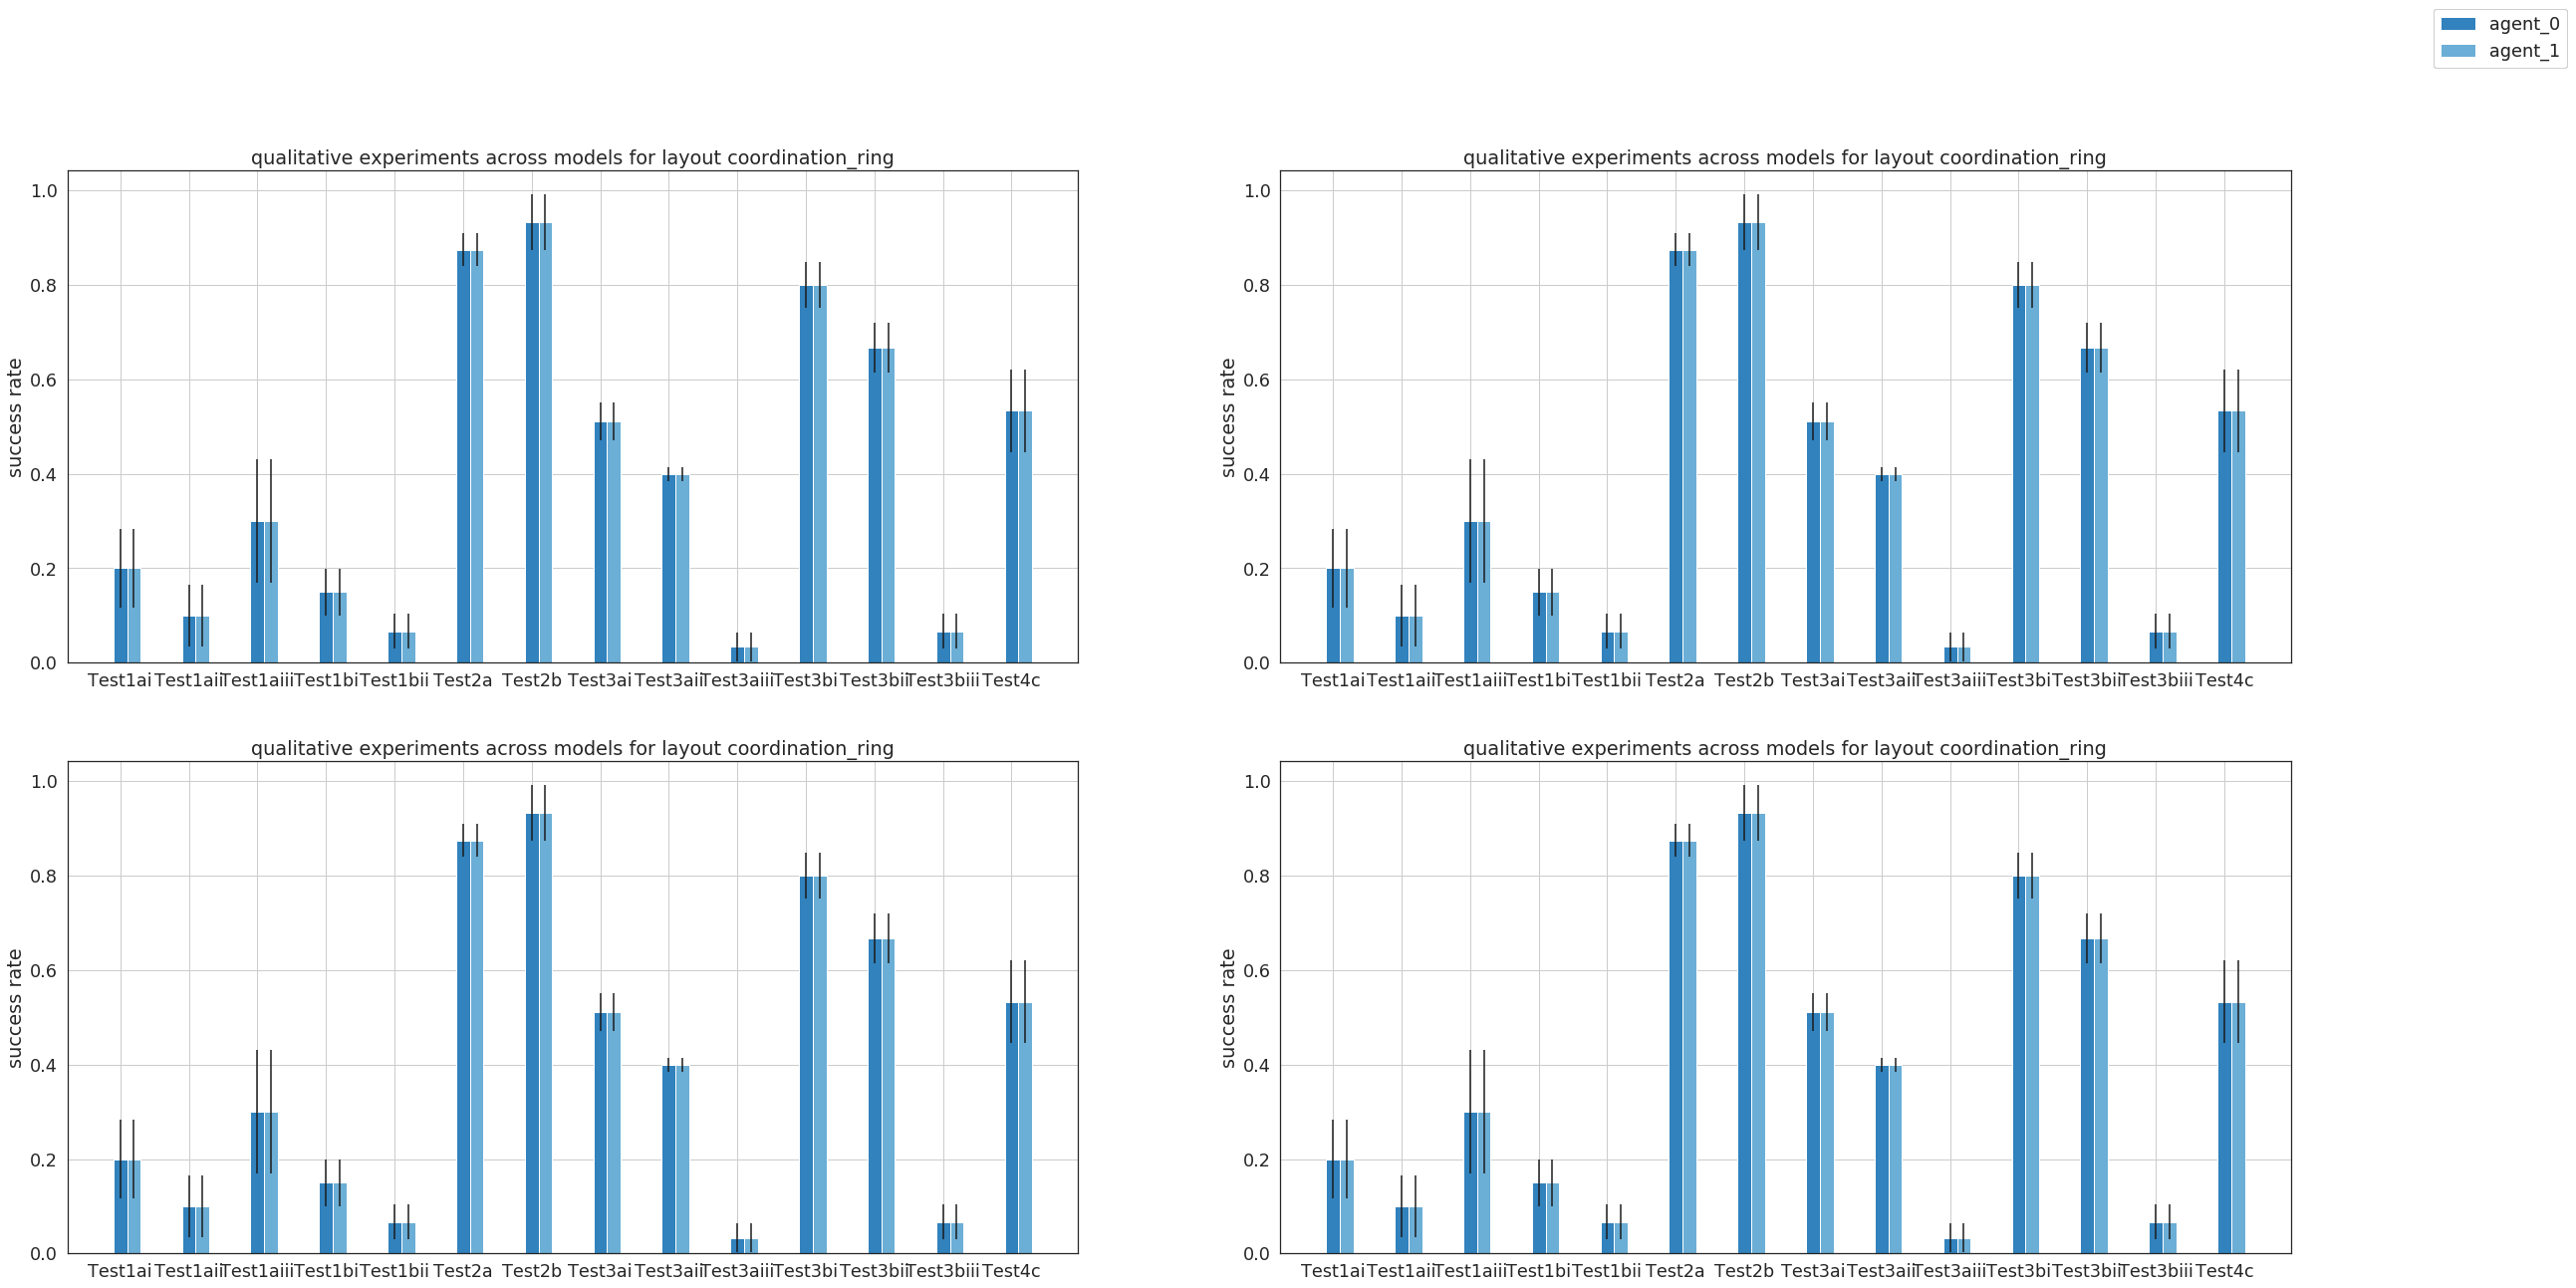

In [261]:
multi_plot_histograms(results_across_layouts, ["coordination_ring", "coordination_ring", "coordination_ring", "coordination_ring"])

## Micah Plotting

In [7]:
def load_test_result(result_name):
    # result_name
    return load_pickle(DATA_DIR + "qual_results_from_server/" + result_name + ".pickle")

In [10]:

layout_code = "bot"
def get_all_results_for_layout(layout_code, filter_fns=[]):
    results_by_agent = {}
    path_prefix = "results_{}_".format(layout_code)
    for num_tom in [1, 20]:
        human_model_types = ["bc", "tom"]
        if num_tom == 20:
            human_model_types.append("mixed")

        for human_model in human_model_types:
            for data_starts in ["s", "ns"]:
                agent_type = "{}{}_{}".format(num_tom, human_model, data_starts)
                results_by_agent[agent_type] = load_test_result(path_prefix + agent_type)

    results_by_agent["5tom_s".format(layout_code)] = load_test_result(path_prefix + "5tom_s")
    results_by_agent["20tomrand_s".format(layout_code)] = load_test_result(path_prefix + "20tomrand_s")
    
    for filter_fn in filter_fns:
        results_by_agent = filter_fn(results_by_agent)
    
    return results_by_agent

# results_by_agent.keys()

In [11]:
def only_keys_containing(d, name):
    d_new = copy.deepcopy(d)
    for k in d.keys():
        if name not in k:
            del d_new[k]
    return d_new
            
def exclude_keys_containing(d, name):
    d_new = copy.deepcopy(d)
    for k in d.keys():
        if name in k:
            del d_new[k]
    return d_new

In [12]:
# All results

LAYOUT_CODES_TO_NAMES = {
    "bot": "bottleneck",
    "rm": "room",
    "cobj": "centre_objects",
    "cpot": "centre_pots",
}

layout_codes = ["bot", "rm",  "cobj", "cpot"] # "cc", "cring"
filter_fns = [
    lambda d: exclude_keys_containing(d, "ns")
]

def make_multi_layout_plots(layout_codes, filter_fns=[], gaps=[], col_size=20):
    across_layout_data = {}
    for layout_code in layout_codes:
        results_by_agent = get_all_results_for_layout(layout_code, filter_fns=filter_fns)

        averaged_by_test_type_results = average_across_different_test_types(results_by_agent)

        across_layout_data[LAYOUT_CODES_TO_NAMES[layout_code]] = averaged_by_test_type_results

    key_ordering = ['1bc_ns', '1bc_s', '1tom_ns', '1tom_s', '5tom_s', '20bc_ns', '20bc_s', '20tom_ns', '20tom_s', '20mixed_ns', '20mixed_s', '20tomrand_s']
    multi_plot_histograms(across_layout_data, [LAYOUT_CODES_TO_NAMES[l] for l in layout_codes], barWidth=0.05, key_ordering=key_ordering, gaps=gaps, col_size=col_size)

In [13]:
make_multi_layout_plots(layout_codes, gaps=[4,5,9])

FileNotFoundError: [Errno 2] No such file or directory: '/home/pmzpk/Dropbox/Pycharm_paulk444/human_ai_robustness/human_ai_robustness/data/qual_results_from_server/results_bot_1bc_s.pickle'

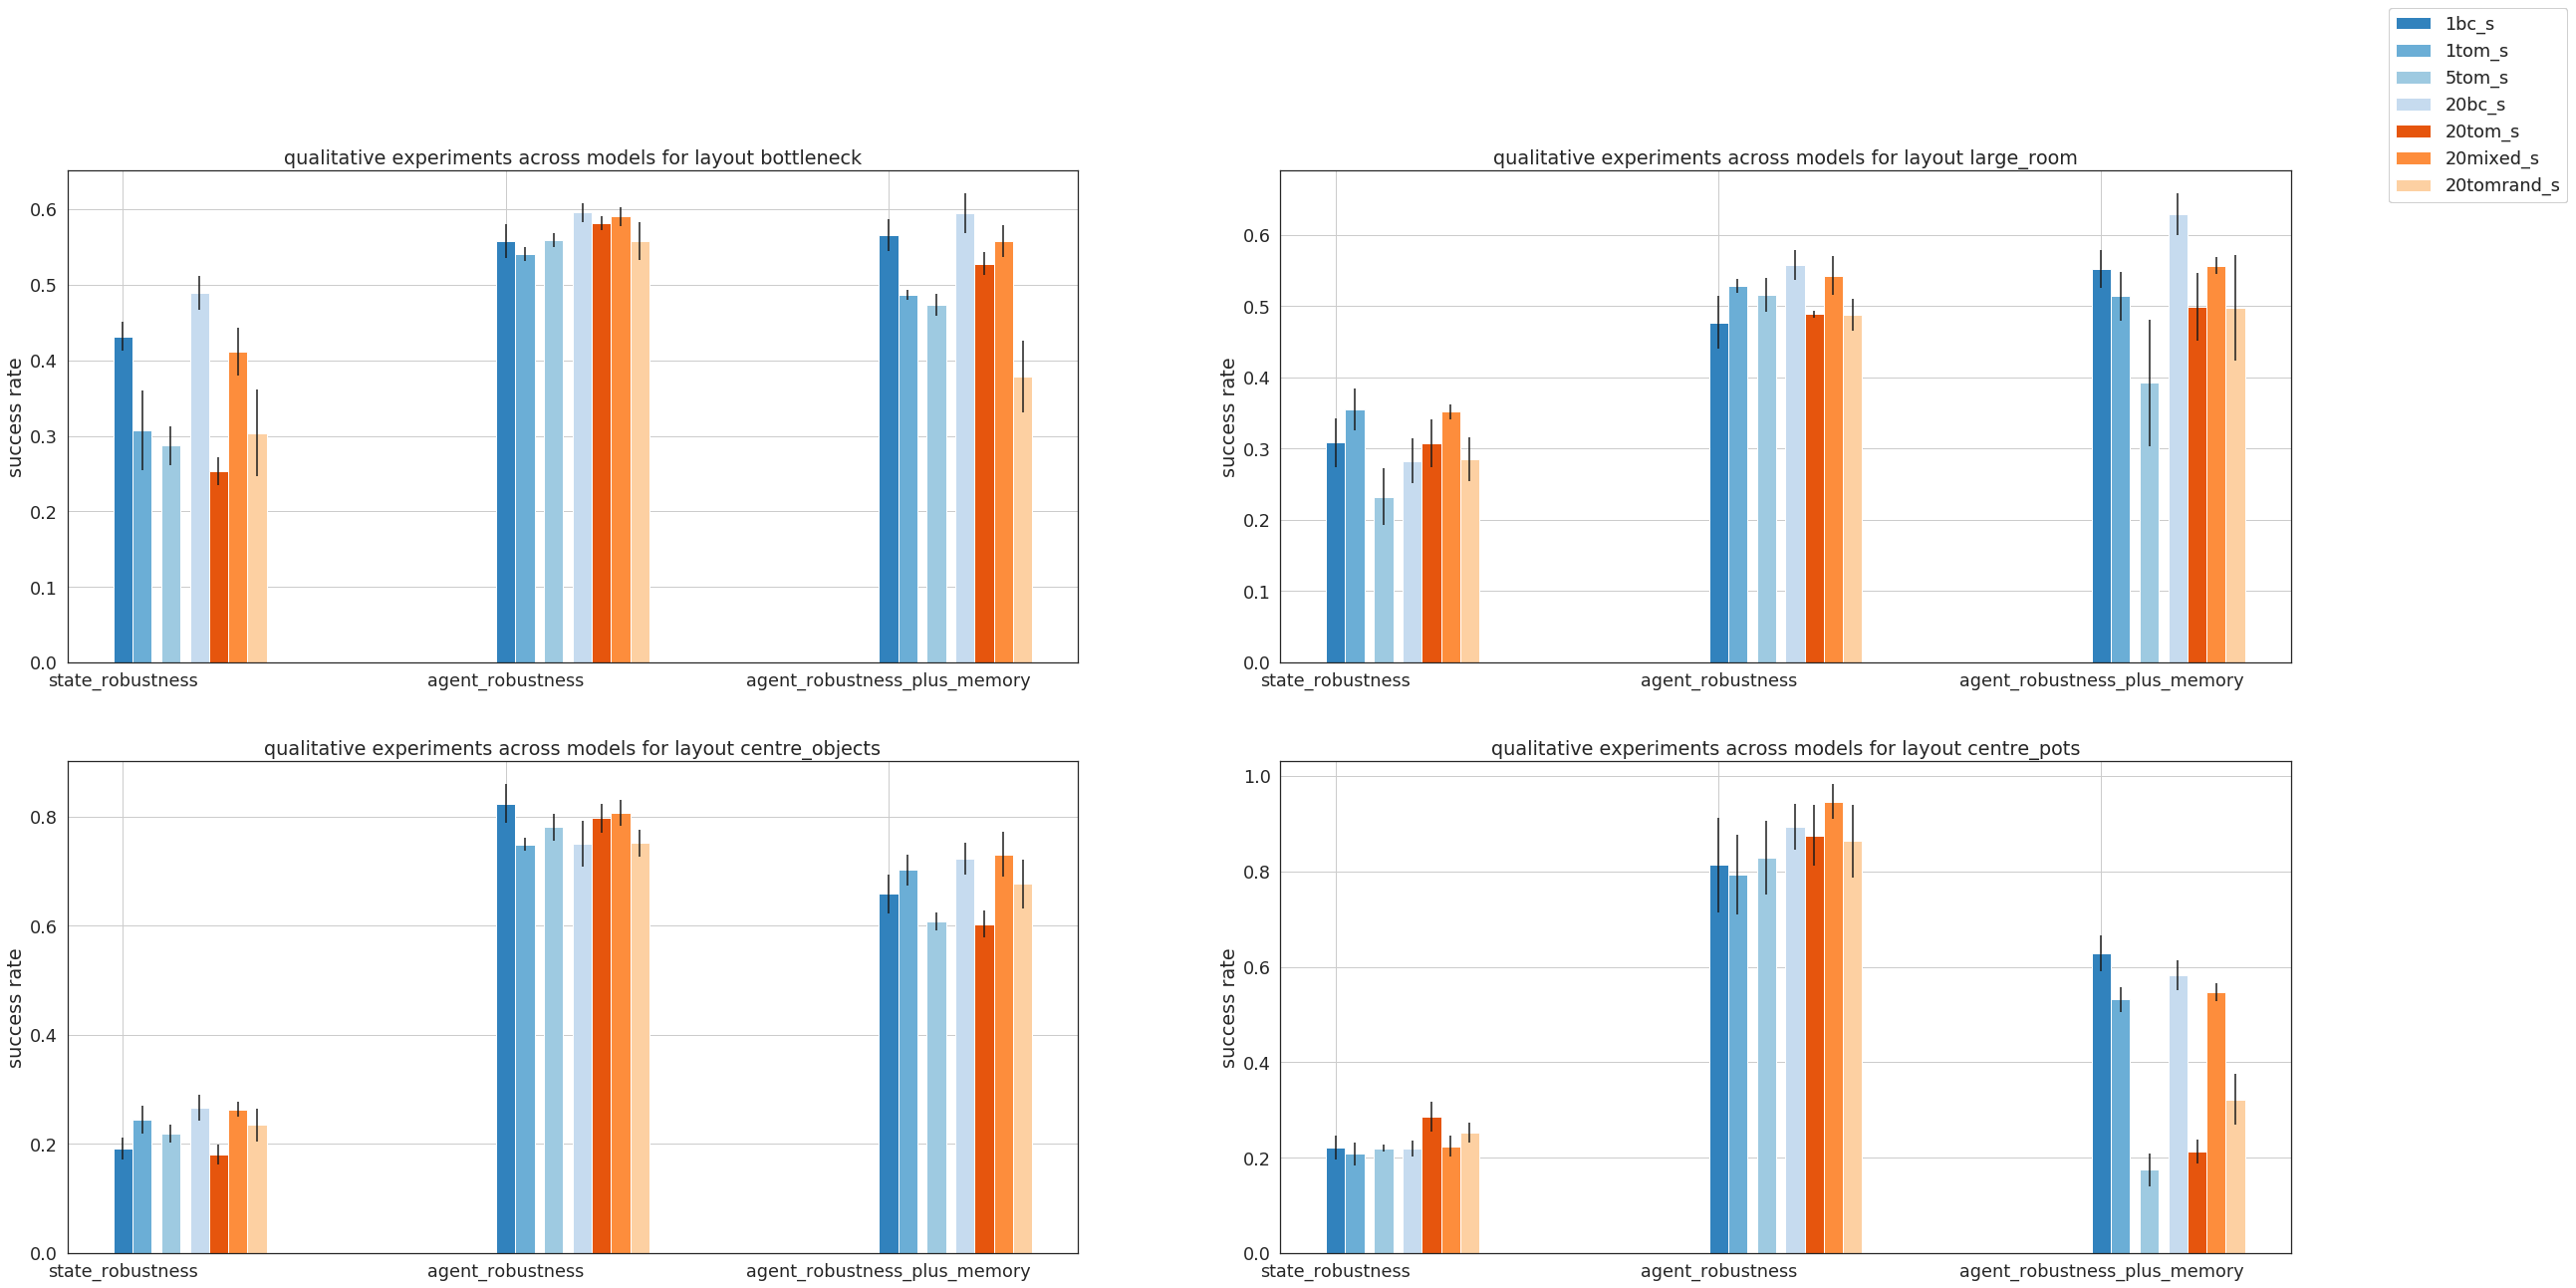

In [288]:
make_multi_layout_plots(layout_codes, filter_fns, gaps=[2, 3], col_size=18)

## Paul's plots based on Micah's code in section "Micah plotting" above

In [ ]:
# Cring and CC

LAYOUT_CODES_TO_NAMES = {
    "bot": "bottleneck",
    "rm": "room",
    "cobj": "centre_objects",
    "cpot": "centre_pots",
    "cc": "counter_circuit",
    "cring": "coordination_ring"
}

layout_codes = ["cc", "cring"] #["bot", "rm",  "cobj", "cpot"]
filter_fns = [
    lambda d: exclude_keys_containing(d, "ns")
]

def make_multi_layout_plots(layout_codes, filter_fns=[], gaps=[], col_size=20):
    across_layout_data = {}
    for layout_code in layout_codes:
        results_by_agent = get_all_results_for_layout(layout_code, filter_fns=filter_fns)

        averaged_by_test_type_results = average_across_different_test_types(results_by_agent)

        across_layout_data[LAYOUT_CODES_TO_NAMES[layout_code]] = averaged_by_test_type_results

    key_ordering = ['1bc_ns', '1bc_s', '1tom_ns', '1tom_s', '5tom_s', '20bc_ns', '20bc_s', '20tom_ns', '20tom_s', '20mixed_ns', '20mixed_s', '20tomrand_s']
    multi_plot_histograms(across_layout_data, [LAYOUT_CODES_TO_NAMES[l] for l in layout_codes], barWidth=0.05, key_ordering=key_ordering, gaps=gaps, col_size=col_size)

## Paul code using correct data types

In [ ]:
# BOTTLENECK

In [51]:
# No starts: 1 vs 20, tom vs bc, with no starts

results_1tom_ns = load_pickle("data/qual_results_from_server/results_bot_1tom_ns.pickle")
results_20tom_ns = load_pickle("data/qual_results_from_server/results_bot_20tom_ns.pickle")
results_1bc_ns = load_pickle("data/qual_results_from_server/results_bot_1bc_ns.pickle")
results_20bc_ns = load_pickle("data/qual_results_from_server/results_bot_20bc_ns.pickle")

# PER-LAYOUT data format
# Standard data format per-layout! Currently assuming that all results in dict are for one specific layout.
results_bot = {
    # Agent name    # Agent results dict as saved by script
    "1tom_ns": results_1tom_ns,
    "20tom_ns": results_20tom_ns,
    "1bc_ns": results_1bc_ns,
    "20bc_ns": results_20bc_ns,
}

def colors_fn(agent_name):
    if agent_name == "1tom_ns":
        return "red"
    elif agent_name == "20tom_ns":
        return "blue"
    elif agent_name == "1bc_ns":
        return "yellow"
    elif agent_name == "20bc_ns":
        return "cyan"
    else:
        raise ValueError("Unrecognized agent type {}. Must define a custom color for this agent type".format(agent_name))
        

Averaging tests with test type state_robustness for agent 1tom_ns
Averaging tests with test type agent_robustness for agent 1tom_ns
Averaging tests with test type agent_robustness_plus_memory for agent 1tom_ns
Averaging tests with test type reward for agent 1tom_ns
Averaging tests with test type state_robustness for agent 20tom_ns
Averaging tests with test type agent_robustness for agent 20tom_ns
Averaging tests with test type agent_robustness_plus_memory for agent 20tom_ns
Averaging tests with test type reward for agent 20tom_ns
Averaging tests with test type state_robustness for agent 1bc_ns
Averaging tests with test type agent_robustness for agent 1bc_ns
Averaging tests with test type agent_robustness_plus_memory for agent 1bc_ns
Averaging tests with test type reward for agent 1bc_ns
Averaging tests with test type state_robustness for agent 20bc_ns
Averaging tests with test type agent_robustness for agent 20bc_ns
Averaging tests with test type agent_robustness_plus_memory for agent 

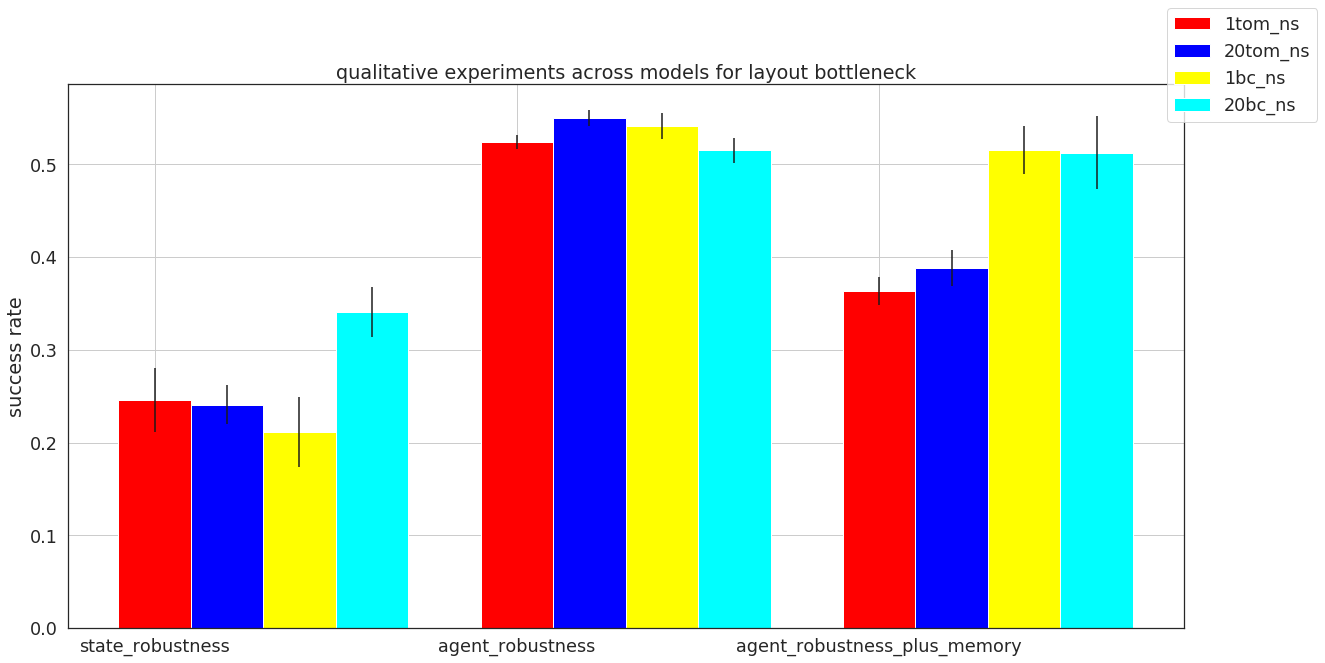

In [52]:
# Or average across all tests of a certain kind, and plot all results on one graph
averaged_by_test_type_results = average_across_different_test_types(results_bot)
simple_layout_histogram(averaged_by_test_type_results)

In [61]:
# Starts vs no starts

results_20tom_ns = load_pickle("data/qual_results_from_server/results_bot_20tom_ns.pickle")
results_20tom_s = load_pickle("data/qual_results_from_server/results_bot_20tom_s.pickle")
results_20mixed_ns = load_pickle("data/qual_results_from_server/results_bot_20mixed_ns.pickle")
results_20mixed_s = load_pickle("data/qual_results_from_server/results_bot_20mixed_s.pickle")

# PER-LAYOUT data format
# Standard data format per-layout! Currently assuming that all results in dict are for one specific layout.
results_bot2 = {
    # Agent name    # Agent results dict as saved by script
    "20tom_ns": results_20tom_ns,
    "20tom_s": results_20tom_s,
    "20mixed_ns": results_20mixed_ns,
    "20mixed_s": results_20mixed_s
}

def colors_fn(agent_name):
    if agent_name == "20tom_ns":
        return "blue"
    elif agent_name == "20tom_s":
        return "cyan"
    elif agent_name == "20mixed_ns":
        return "magenta"
    elif agent_name == "20mixed_s":
        return "green"
    else:
        raise ValueError("Unrecognized agent type {}. Must define a custom color for this agent type".format(agent_name))
        

Averaging tests with test type state_robustness for agent 20tom_ns
Averaging tests with test type agent_robustness for agent 20tom_ns
Averaging tests with test type agent_robustness_plus_memory for agent 20tom_ns
Averaging tests with test type reward for agent 20tom_ns
Averaging tests with test type state_robustness for agent 20tom_s
Averaging tests with test type agent_robustness for agent 20tom_s
Averaging tests with test type agent_robustness_plus_memory for agent 20tom_s
Averaging tests with test type reward for agent 20tom_s
Averaging tests with test type state_robustness for agent 20mixed_ns
Averaging tests with test type agent_robustness for agent 20mixed_ns
Averaging tests with test type agent_robustness_plus_memory for agent 20mixed_ns
Averaging tests with test type reward for agent 20mixed_ns
Averaging tests with test type state_robustness for agent 20mixed_s
Averaging tests with test type agent_robustness for agent 20mixed_s
Averaging tests with test type agent_robustness_pl

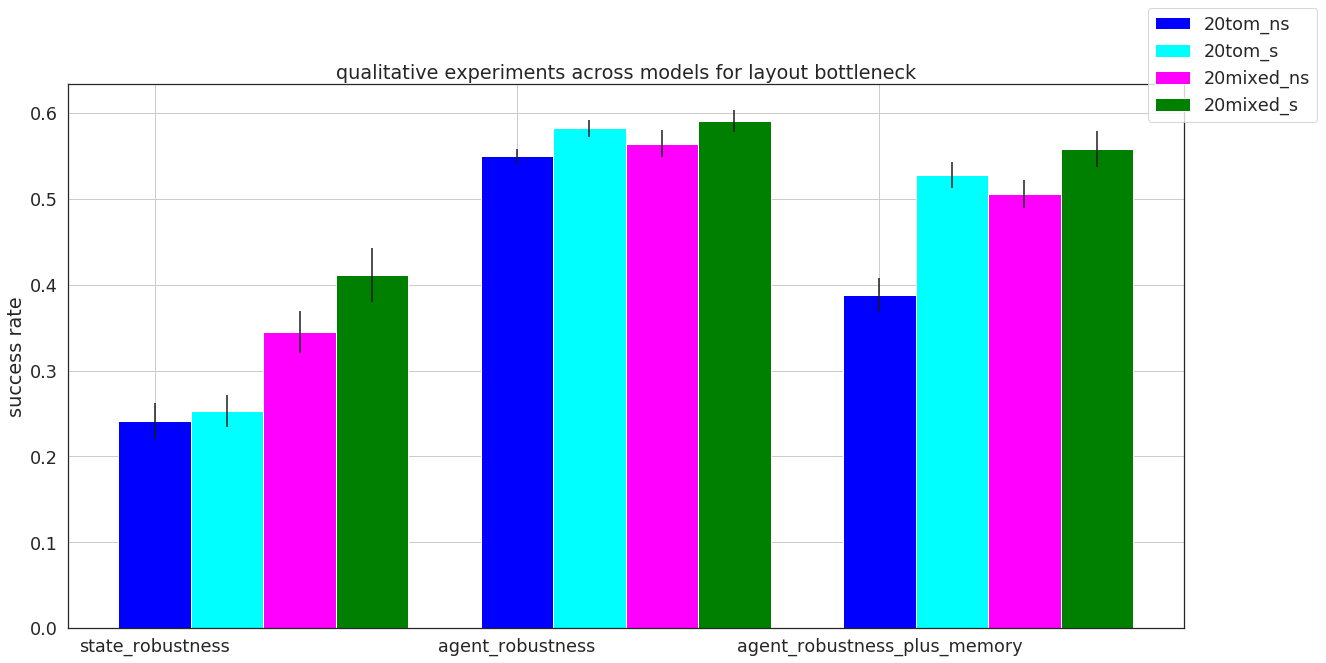

In [62]:
# Or average across all tests of a certain kind, and plot all results on one graph
averaged_by_test_type_results = average_across_different_test_types(results_bot2)
simple_layout_histogram(averaged_by_test_type_results)

In [73]:
# Different pops WITH data starts

results_1tom_s = load_pickle("data/qual_results_from_server/results_bot_1tom_s.pickle")
results_5tom_s = load_pickle("data/qual_results_from_server/results_bot_5tom_s.pickle")
results_20tom_s = load_pickle("data/qual_results_from_server/results_bot_20tom_s.pickle")
results_20tomrand_s = load_pickle("data/qual_results_from_server/results_bot_20tomrand_s.pickle")
# results_20mixed_s = load_pickle("data/qual_results_from_server/results_bot_20mixed_s.pickle")

# PER-LAYOUT data format
# Standard data format per-layout! Currently assuming that all results in dict are for one specific layout.
results_bot3 = {
    # Agent name    # Agent results dict as saved by script
    "1tom_s": results_1tom_s,
    "5tom_s": results_5tom_s,
    "20tom_s": results_20tom_s,
    "20tomrand_s": results_20tomrand_s,
#     "20mixed_s": results_20mixed_s
}

def colors_fn(agent_name):
    if agent_name == "1tom_s":
        return "red"
    elif agent_name == "5tom_s":
        return "green"
    elif agent_name == "20tom_s":
        return "blue"
    elif agent_name == "20tomrand_s":
        return "yellow"
#     elif agent_name == "20mixed_s":
#         return "cyan"
    else:
        raise ValueError("Unrecognized agent type {}. Must define a custom color for this agent type".format(agent_name))
        

Averaging tests with test type state_robustness for agent 1tom_s
Averaging tests with test type agent_robustness for agent 1tom_s
Averaging tests with test type agent_robustness_plus_memory for agent 1tom_s
Averaging tests with test type reward for agent 1tom_s
Averaging tests with test type state_robustness for agent 5tom_s
Averaging tests with test type agent_robustness for agent 5tom_s
Averaging tests with test type agent_robustness_plus_memory for agent 5tom_s
Averaging tests with test type reward for agent 5tom_s
Averaging tests with test type state_robustness for agent 20tom_s
Averaging tests with test type agent_robustness for agent 20tom_s
Averaging tests with test type agent_robustness_plus_memory for agent 20tom_s
Averaging tests with test type reward for agent 20tom_s
Averaging tests with test type state_robustness for agent 20tomrand_s
Averaging tests with test type agent_robustness for agent 20tomrand_s
Averaging tests with test type agent_robustness_plus_memory for agent 

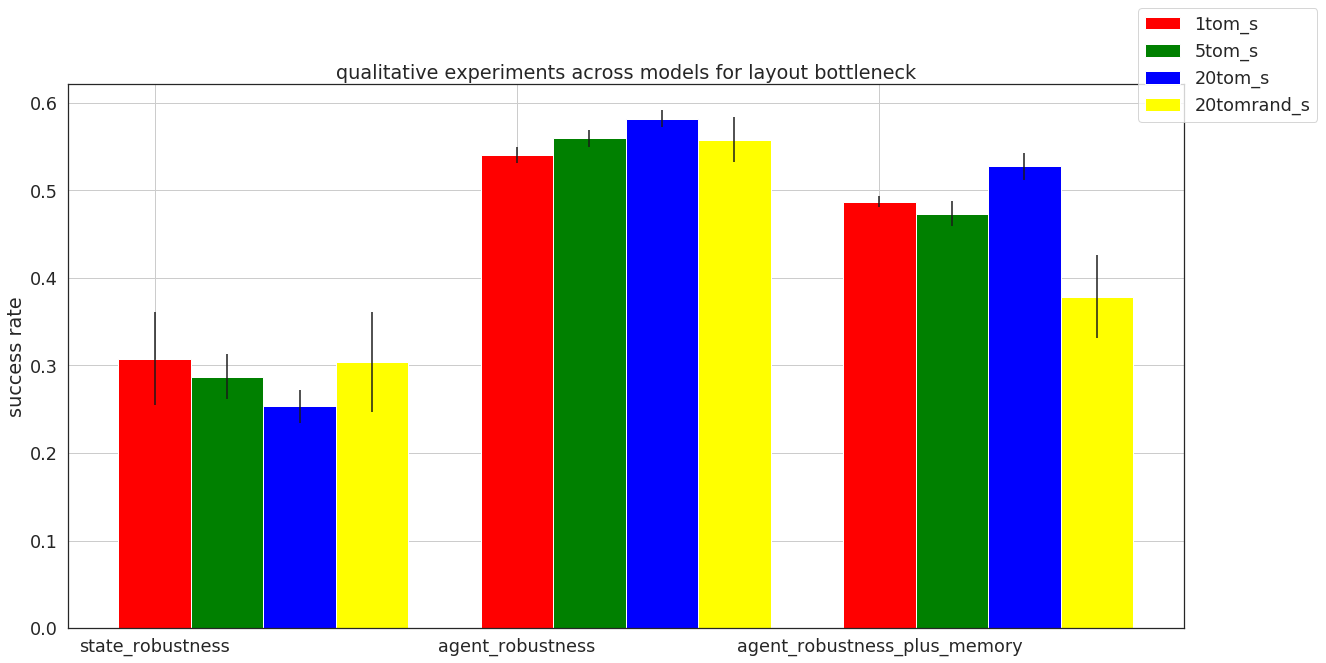

In [74]:
# Or average across all tests of a certain kind, and plot all results on one graph
averaged_by_test_type_results = average_across_different_test_types(results_bot3)
simple_layout_histogram(averaged_by_test_type_results)

In [ ]:
# LARGE ROOM

In [75]:
# No starts: 1 vs 20, tom vs bc, with no starts

results_1tom_ns = load_pickle("data/qual_results_from_server/results_rm_1tom_ns.pickle")
results_20tom_ns = load_pickle("data/qual_results_from_server/results_rm_20tom_ns.pickle")
results_1bc_ns = load_pickle("data/qual_results_from_server/results_rm_1bc_ns.pickle")
results_20bc_ns = load_pickle("data/qual_results_from_server/results_rm_20bc_ns.pickle")

# PER-LAYOUT data format
# Standard data format per-layout! Currently assuming that all results in dict are for one specific layout.
results_rm = {
    # Agent name    # Agent results dict as saved by script
    "1tom_ns": results_1tom_ns,
    "20tom_ns": results_20tom_ns,
    "1bc_ns": results_1bc_ns,
    "20bc_ns": results_20bc_ns,
}

def colors_fn(agent_name):
    if agent_name == "1tom_ns":
        return "red"
    elif agent_name == "20tom_ns":
        return "blue"
    elif agent_name == "1bc_ns":
        return "yellow"
    elif agent_name == "20bc_ns":
        return "cyan"
    else:
        raise ValueError("Unrecognized agent type {}. Must define a custom color for this agent type".format(agent_name))

Averaging tests with test type state_robustness for agent 1tom_ns
Averaging tests with test type agent_robustness for agent 1tom_ns
Averaging tests with test type agent_robustness_plus_memory for agent 1tom_ns
Averaging tests with test type reward for agent 1tom_ns
Averaging tests with test type state_robustness for agent 20tom_ns
Averaging tests with test type agent_robustness for agent 20tom_ns
Averaging tests with test type agent_robustness_plus_memory for agent 20tom_ns
Averaging tests with test type reward for agent 20tom_ns
Averaging tests with test type state_robustness for agent 1bc_ns
Averaging tests with test type agent_robustness for agent 1bc_ns
Averaging tests with test type agent_robustness_plus_memory for agent 1bc_ns
Averaging tests with test type reward for agent 1bc_ns
Averaging tests with test type state_robustness for agent 20bc_ns
Averaging tests with test type agent_robustness for agent 20bc_ns
Averaging tests with test type agent_robustness_plus_memory for agent 

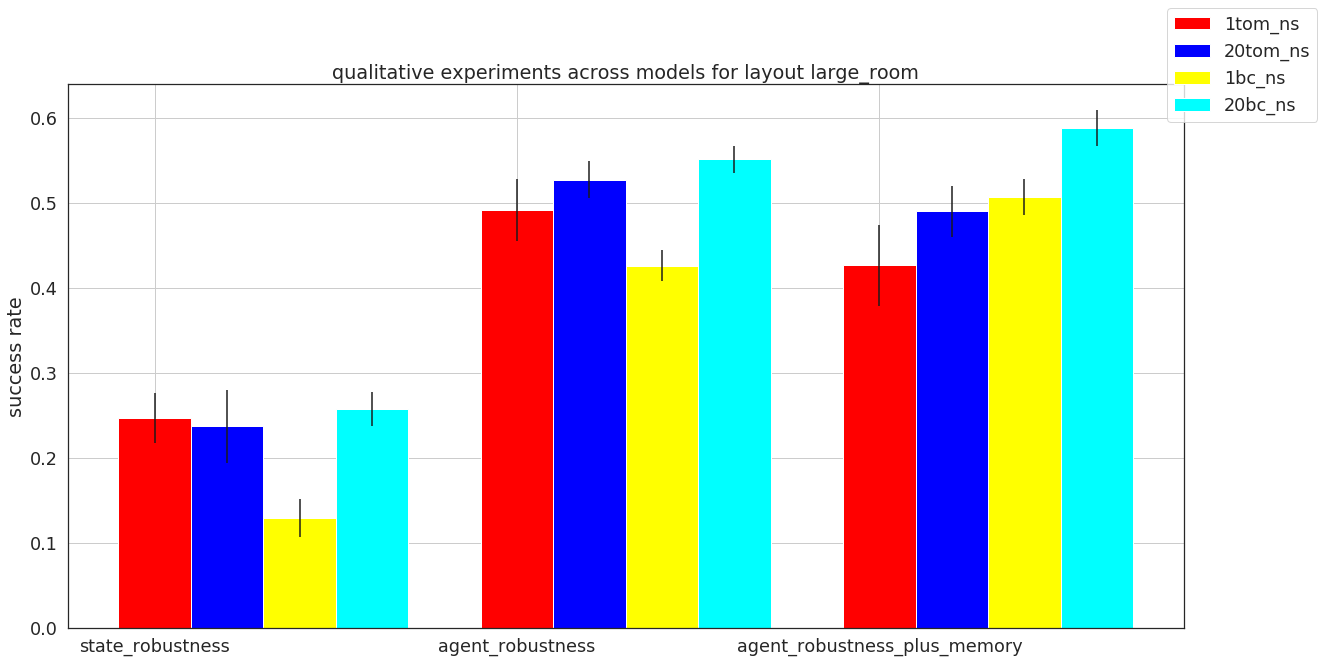

In [77]:
# Or average across all tests of a certain kind, and plot all results on one graph
averaged_by_test_type_results = average_across_different_test_types(results_rm)
simple_layout_histogram(averaged_by_test_type_results)

In [78]:
# Starts vs no starts

results_20tom_ns = load_pickle("data/qual_results_from_server/results_rm_20tom_ns.pickle")
results_20tom_s = load_pickle("data/qual_results_from_server/results_rm_20tom_s.pickle")
results_20mixed_ns = load_pickle("data/qual_results_from_server/results_rm_20mixed_ns.pickle")
results_20mixed_s = load_pickle("data/qual_results_from_server/results_rm_20mixed_s.pickle")

# PER-LAYOUT data format
# Standard data format per-layout! Currently assuming that all results in dict are for one specific layout.
results_rm2 = {
    # Agent name    # Agent results dict as saved by script
    "20tom_ns": results_20tom_ns,
    "20tom_s": results_20tom_s,
    "20mixed_ns": results_20mixed_ns,
    "20mixed_s": results_20mixed_s
}

def colors_fn(agent_name):
    if agent_name == "20tom_ns":
        return "blue"
    elif agent_name == "20tom_s":
        return "cyan"
    elif agent_name == "20mixed_ns":
        return "magenta"
    elif agent_name == "20mixed_s":
        return "green"
    else:
        raise ValueError("Unrecognized agent type {}. Must define a custom color for this agent type".format(agent_name))
        

Averaging tests with test type state_robustness for agent 20tom_ns
Averaging tests with test type agent_robustness for agent 20tom_ns
Averaging tests with test type agent_robustness_plus_memory for agent 20tom_ns
Averaging tests with test type reward for agent 20tom_ns
Averaging tests with test type state_robustness for agent 20tom_s
Averaging tests with test type agent_robustness for agent 20tom_s
Averaging tests with test type agent_robustness_plus_memory for agent 20tom_s
Averaging tests with test type reward for agent 20tom_s
Averaging tests with test type state_robustness for agent 20mixed_ns
Averaging tests with test type agent_robustness for agent 20mixed_ns
Averaging tests with test type agent_robustness_plus_memory for agent 20mixed_ns
Averaging tests with test type reward for agent 20mixed_ns
Averaging tests with test type state_robustness for agent 20mixed_s
Averaging tests with test type agent_robustness for agent 20mixed_s
Averaging tests with test type agent_robustness_pl

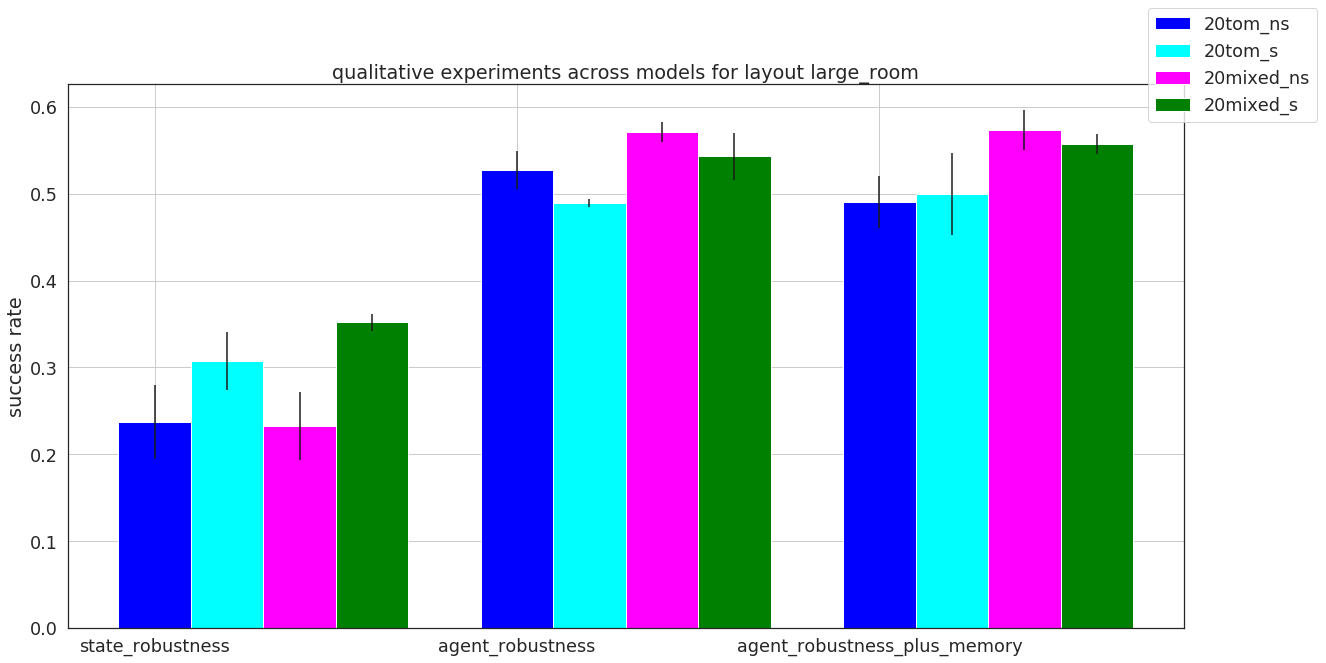

In [79]:
# Or average across all tests of a certain kind, and plot all results on one graph
averaged_by_test_type_results = average_across_different_test_types(results_rm2)
simple_layout_histogram(averaged_by_test_type_results)

In [80]:
# Different pops WITH data starts

results_1tom_s = load_pickle("data/qual_results_from_server/results_rm_1tom_s.pickle")
results_5tom_s = load_pickle("data/qual_results_from_server/results_rm_5tom_s.pickle")
results_20tom_s = load_pickle("data/qual_results_from_server/results_rm_20tom_s.pickle")
results_20tomrand_s = load_pickle("data/qual_results_from_server/results_rm_20tomrand_s.pickle")
# results_20mixed_s = load_pickle("data/qual_results_from_server/results_rm_20mixed_s.pickle")

# PER-LAYOUT data format
# Standard data format per-layout! Currently assuming that all results in dict are for one specific layout.
results_rm3 = {
    # Agent name    # Agent results dict as saved by script
    "1tom_s": results_1tom_s,
    "5tom_s": results_5tom_s,
    "20tom_s": results_20tom_s,
    "20tomrand_s": results_20tomrand_s,
#     "20mixed_s": results_20mixed_s
}

def colors_fn(agent_name):
    if agent_name == "1tom_s":
        return "red"
    elif agent_name == "5tom_s":
        return "green"
    elif agent_name == "20tom_s":
        return "blue"
    elif agent_name == "20tomrand_s":
        return "yellow"
#     elif agent_name == "20mixed_s":
#         return "cyan"
    else:
        raise ValueError("Unrecognized agent type {}. Must define a custom color for this agent type".format(agent_name))
        

Averaging tests with test type state_robustness for agent 1tom_s
Averaging tests with test type agent_robustness for agent 1tom_s
Averaging tests with test type agent_robustness_plus_memory for agent 1tom_s
Averaging tests with test type reward for agent 1tom_s
Averaging tests with test type state_robustness for agent 5tom_s
Averaging tests with test type agent_robustness for agent 5tom_s
Averaging tests with test type agent_robustness_plus_memory for agent 5tom_s
Averaging tests with test type reward for agent 5tom_s
Averaging tests with test type state_robustness for agent 20tom_s
Averaging tests with test type agent_robustness for agent 20tom_s
Averaging tests with test type agent_robustness_plus_memory for agent 20tom_s
Averaging tests with test type reward for agent 20tom_s
Averaging tests with test type state_robustness for agent 20tomrand_s
Averaging tests with test type agent_robustness for agent 20tomrand_s
Averaging tests with test type agent_robustness_plus_memory for agent 

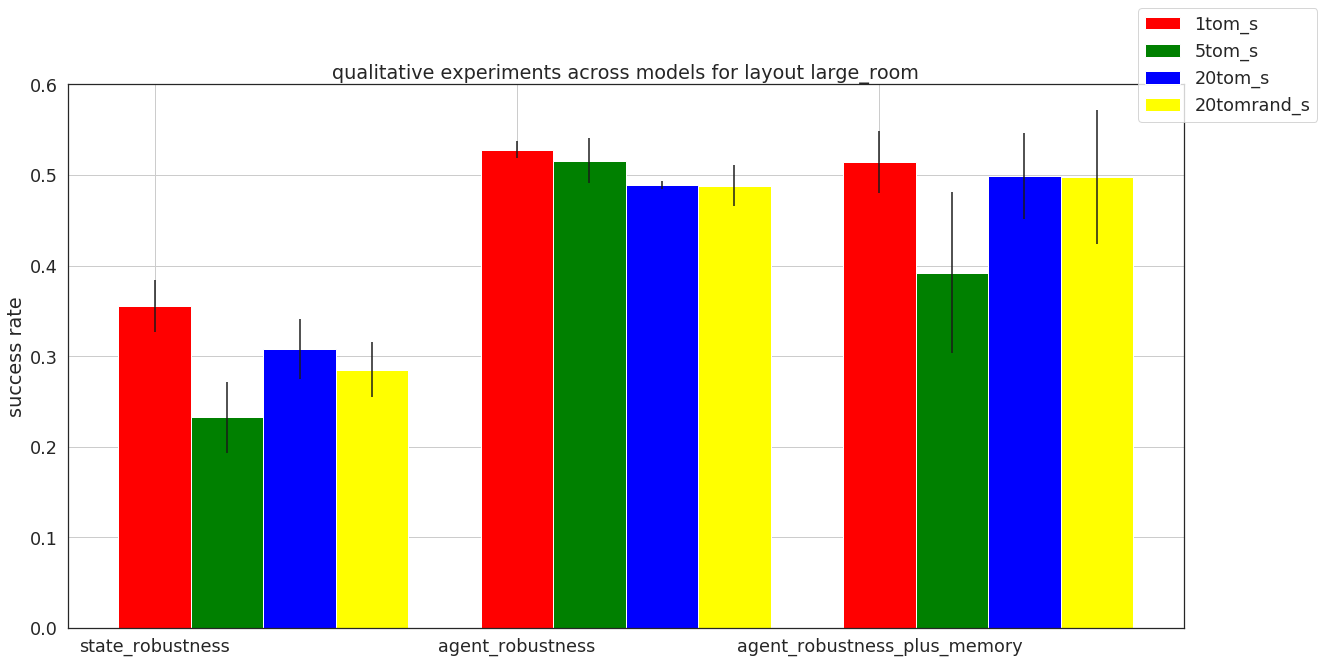

In [81]:
# Or average across all tests of a certain kind, and plot all results on one graph
averaged_by_test_type_results = average_across_different_test_types(results_rm3)
simple_layout_histogram(averaged_by_test_type_results)

In [ ]:
# CENTRE POTS

In [6]:
# No starts: 1 vs 20, tom vs bc, with no starts

results_1tom_ns = load_pickle("data/qual_results_from_server/results_cpot_1tom_ns.pickle")
results_20tom_ns = load_pickle("data/qual_results_from_server/results_cpot_20tom_ns.pickle")
results_1bc_ns = load_pickle("data/qual_results_from_server/results_cpot_1bc_ns.pickle")
results_20bc_ns = load_pickle("data/qual_results_from_server/results_cpot_20bc_ns.pickle")

# PER-LAYOUT data format
# Standard data format per-layout! Currently assuming that all results in dict are for one specific layout.
results_cpot = {
    # Agent name    # Agent results dict as saved by script
    "1tom_ns": results_1tom_ns,
    "20tom_ns": results_20tom_ns,
    "1bc_ns": results_1bc_ns,
    "20bc_ns": results_20bc_ns,
}

def colors_fn(agent_name):
    if agent_name == "1tom_ns":
        return "red"
    elif agent_name == "20tom_ns":
        return "blue"
    elif agent_name == "1bc_ns":
        return "yellow"
    elif agent_name == "20bc_ns":
        return "cyan"
    else:
        raise ValueError("Unrecognized agent type {}. Must define a custom color for this agent type".format(agent_name))

Averaging tests with test type state_robustness for agent 1tom_ns
Averaging tests with test type agent_robustness for agent 1tom_ns
Averaging tests with test type agent_robustness_plus_memory for agent 1tom_ns
Averaging tests with test type reward for agent 1tom_ns
Averaging tests with test type state_robustness for agent 20tom_ns
Averaging tests with test type agent_robustness for agent 20tom_ns
Averaging tests with test type agent_robustness_plus_memory for agent 20tom_ns
Averaging tests with test type reward for agent 20tom_ns
Averaging tests with test type state_robustness for agent 1bc_ns
Averaging tests with test type agent_robustness for agent 1bc_ns
Averaging tests with test type agent_robustness_plus_memory for agent 1bc_ns
Averaging tests with test type reward for agent 1bc_ns
Averaging tests with test type state_robustness for agent 20bc_ns
Averaging tests with test type agent_robustness for agent 20bc_ns
Averaging tests with test type agent_robustness_plus_memory for agent 

/home/pmzpk/miniconda3/envs/hrc/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


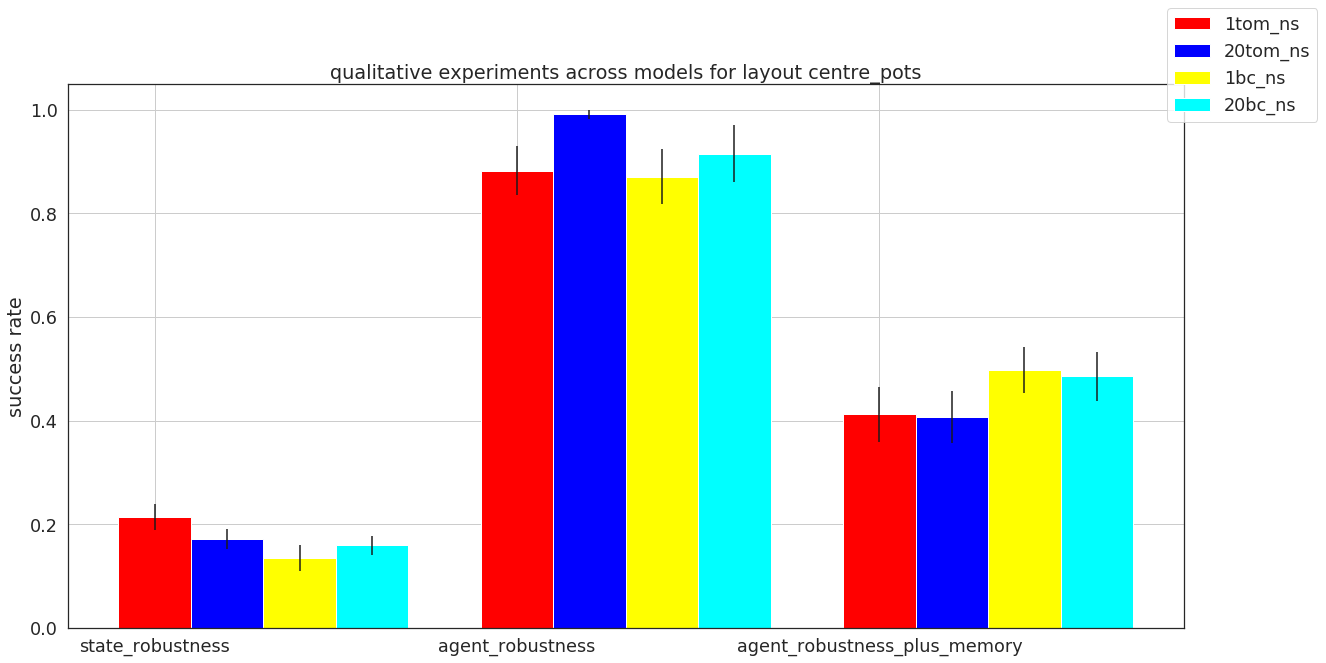

In [7]:
# Or average across all tests of a certain kind, and plot all results on one graph
averaged_by_test_type_results = average_across_different_test_types(results_cpot)
simple_layout_histogram(averaged_by_test_type_results)

In [8]:
# Starts vs no starts

results_20tom_ns = load_pickle("data/qual_results_from_server/results_cpot_20tom_ns.pickle")
results_20tom_s = load_pickle("data/qual_results_from_server/results_cpot_20tom_s.pickle")
results_20mixed_ns = load_pickle("data/qual_results_from_server/results_cpot_20mixed_ns.pickle")
results_20mixed_s = load_pickle("data/qual_results_from_server/results_cpot_20mixed_s.pickle")

# PER-LAYOUT data format
# Standard data format per-layout! Currently assuming that all results in dict are for one specific layout.
results_cpot2 = {
    # Agent name    # Agent results dict as saved by script
    "20tom_ns": results_20tom_ns,
    "20tom_s": results_20tom_s,
    "20mixed_ns": results_20mixed_ns,
    "20mixed_s": results_20mixed_s
}

def colors_fn(agent_name):
    if agent_name == "20tom_ns":
        return "blue"
    elif agent_name == "20tom_s":
        return "cyan"
    elif agent_name == "20mixed_ns":
        return "magenta"
    elif agent_name == "20mixed_s":
        return "green"
    else:
        raise ValueError("Unrecognized agent type {}. Must define a custom color for this agent type".format(agent_name))
        

Averaging tests with test type state_robustness for agent 20tom_ns
Averaging tests with test type agent_robustness for agent 20tom_ns
Averaging tests with test type agent_robustness_plus_memory for agent 20tom_ns
Averaging tests with test type reward for agent 20tom_ns
Averaging tests with test type state_robustness for agent 20tom_s
Averaging tests with test type agent_robustness for agent 20tom_s
Averaging tests with test type agent_robustness_plus_memory for agent 20tom_s
Averaging tests with test type reward for agent 20tom_s
Averaging tests with test type state_robustness for agent 20mixed_ns
Averaging tests with test type agent_robustness for agent 20mixed_ns
Averaging tests with test type agent_robustness_plus_memory for agent 20mixed_ns
Averaging tests with test type reward for agent 20mixed_ns
Averaging tests with test type state_robustness for agent 20mixed_s
Averaging tests with test type agent_robustness for agent 20mixed_s
Averaging tests with test type agent_robustness_pl

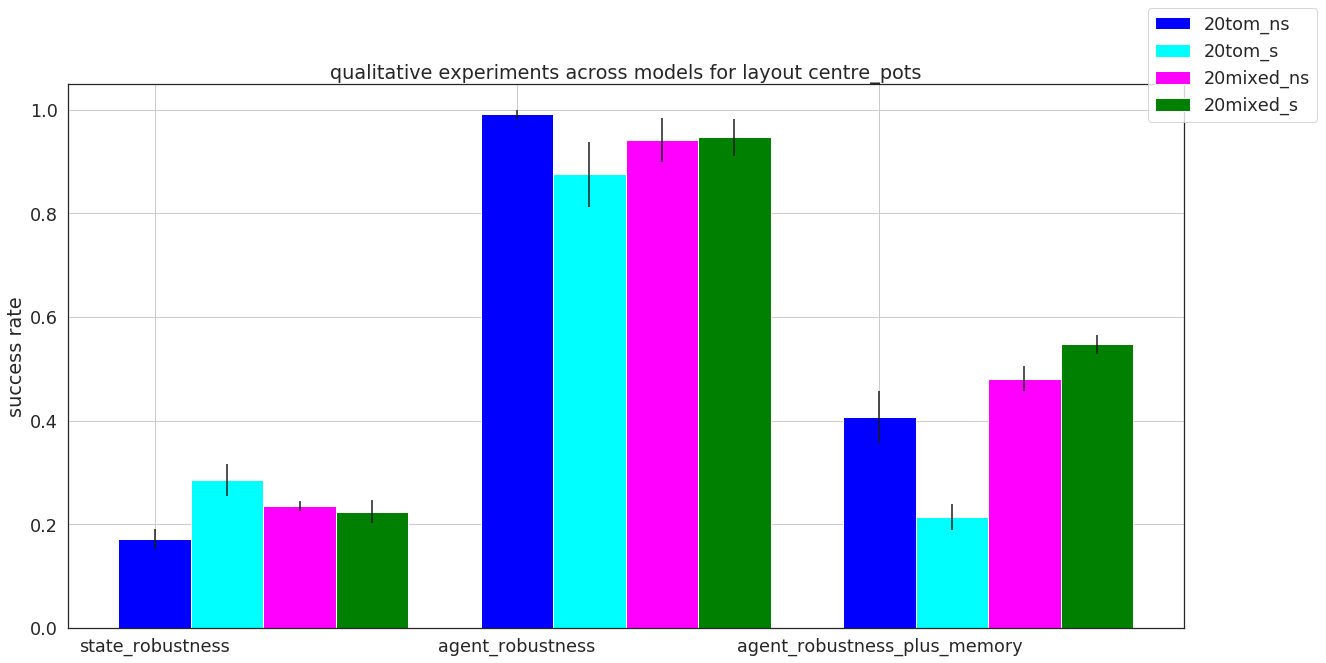

In [9]:
# Or average across all tests of a certain kind, and plot all results on one graph
averaged_by_test_type_results = average_across_different_test_types(results_cpot2)
simple_layout_histogram(averaged_by_test_type_results)

In [10]:
# Different pops WITH data starts

results_1tom_s = load_pickle("data/qual_results_from_server/results_cpot_1tom_s.pickle")
results_5tom_s = load_pickle("data/qual_results_from_server/results_cpot_5tom_s.pickle")
results_20tom_s = load_pickle("data/qual_results_from_server/results_cpot_20tom_s.pickle")
results_20tomrand_s = load_pickle("data/qual_results_from_server/results_cpot_20tomrand_s.pickle")
# results_20mixed_s = load_pickle("data/qual_results_from_server/results_cpot_20mixed_s.pickle")

# PER-LAYOUT data format
# Standard data format per-layout! Currently assuming that all results in dict are for one specific layout.
results_cpot3 = {
    # Agent name    # Agent results dict as saved by script
    "1tom_s": results_1tom_s,
    "5tom_s": results_5tom_s,
    "20tom_s": results_20tom_s,
    "20tomrand_s": results_20tomrand_s,
#     "20mixed_s": results_20mixed_s
}

def colors_fn(agent_name):
    if agent_name == "1tom_s":
        return "red"
    elif agent_name == "5tom_s":
        return "green"
    elif agent_name == "20tom_s":
        return "blue"
    elif agent_name == "20tomrand_s":
        return "yellow"
#     elif agent_name == "20mixed_s":
#         return "cyan"
    else:
        raise ValueError("Unrecognized agent type {}. Must define a custom color for this agent type".format(agent_name))
        

Averaging tests with test type state_robustness for agent 1tom_s
Averaging tests with test type agent_robustness for agent 1tom_s
Averaging tests with test type agent_robustness_plus_memory for agent 1tom_s
Averaging tests with test type reward for agent 1tom_s
Averaging tests with test type state_robustness for agent 5tom_s
Averaging tests with test type agent_robustness for agent 5tom_s
Averaging tests with test type agent_robustness_plus_memory for agent 5tom_s
Averaging tests with test type reward for agent 5tom_s
Averaging tests with test type state_robustness for agent 20tom_s
Averaging tests with test type agent_robustness for agent 20tom_s
Averaging tests with test type agent_robustness_plus_memory for agent 20tom_s
Averaging tests with test type reward for agent 20tom_s
Averaging tests with test type state_robustness for agent 20tomrand_s
Averaging tests with test type agent_robustness for agent 20tomrand_s
Averaging tests with test type agent_robustness_plus_memory for agent 

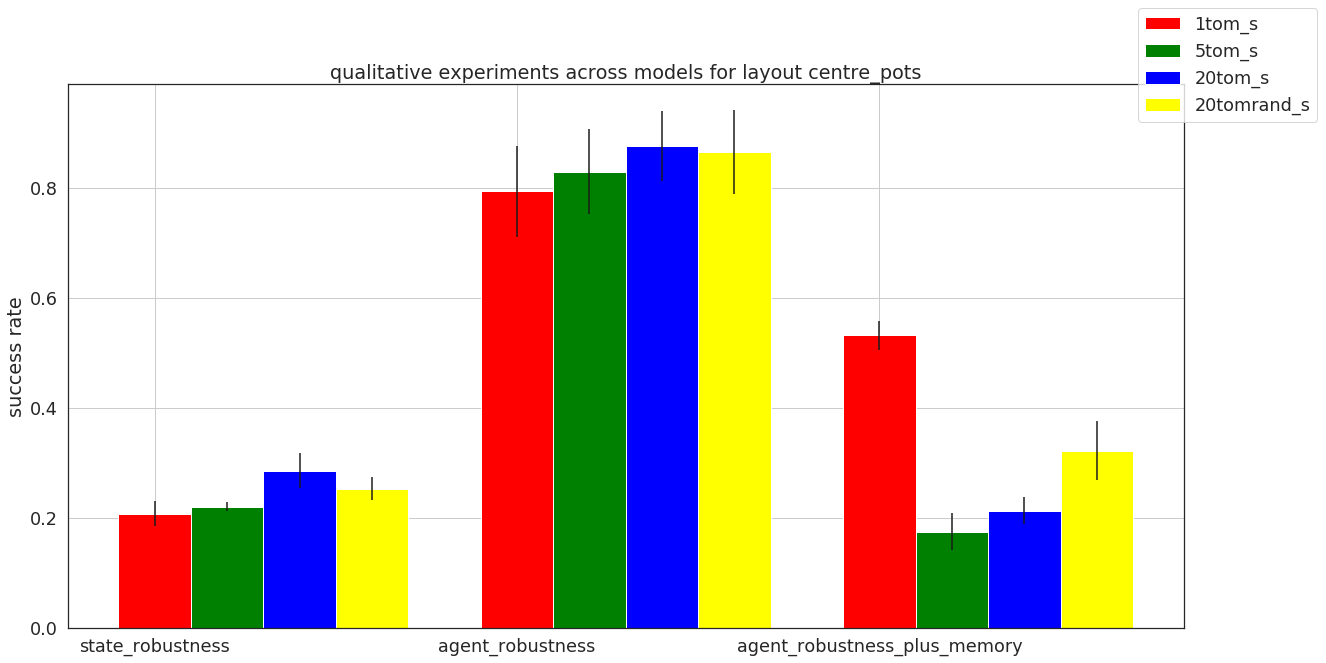

In [12]:
# Or average across all tests of a certain kind, and plot all results on one graph
averaged_by_test_type_results = average_across_different_test_types(results_cpot3)
simple_layout_histogram(averaged_by_test_type_results)

In [ ]:
# CENTRE OBJECTS

In [13]:
# No starts: 1 vs 20, tom vs bc, with no starts

results_1tom_ns = load_pickle("data/qual_results_from_server/results_cobj_1tom_ns.pickle")
results_20tom_ns = load_pickle("data/qual_results_from_server/results_cobj_20tom_ns.pickle")
results_1bc_ns = load_pickle("data/qual_results_from_server/results_cobj_1bc_ns.pickle")
results_20bc_ns = load_pickle("data/qual_results_from_server/results_cobj_20bc_ns.pickle")

# PER-LAYOUT data format
# Standard data format per-layout! Currently assuming that all results in dict are for one specific layout.
results_cobj = {
    # Agent name    # Agent results dict as saved by script
    "1tom_ns": results_1tom_ns,
    "20tom_ns": results_20tom_ns,
    "1bc_ns": results_1bc_ns,
    "20bc_ns": results_20bc_ns,
}

def colors_fn(agent_name):
    if agent_name == "1tom_ns":
        return "red"
    elif agent_name == "20tom_ns":
        return "blue"
    elif agent_name == "1bc_ns":
        return "yellow"
    elif agent_name == "20bc_ns":
        return "cyan"
    else:
        raise ValueError("Unrecognized agent type {}. Must define a custom color for this agent type".format(agent_name))
        


Averaging tests with test type state_robustness for agent 1tom_ns
Averaging tests with test type agent_robustness for agent 1tom_ns
Averaging tests with test type agent_robustness_plus_memory for agent 1tom_ns
Averaging tests with test type reward for agent 1tom_ns
Averaging tests with test type state_robustness for agent 20tom_ns
Averaging tests with test type agent_robustness for agent 20tom_ns
Averaging tests with test type agent_robustness_plus_memory for agent 20tom_ns
Averaging tests with test type reward for agent 20tom_ns
Averaging tests with test type state_robustness for agent 1bc_ns
Averaging tests with test type agent_robustness for agent 1bc_ns
Averaging tests with test type agent_robustness_plus_memory for agent 1bc_ns
Averaging tests with test type reward for agent 1bc_ns
Averaging tests with test type state_robustness for agent 20bc_ns
Averaging tests with test type agent_robustness for agent 20bc_ns
Averaging tests with test type agent_robustness_plus_memory for agent 

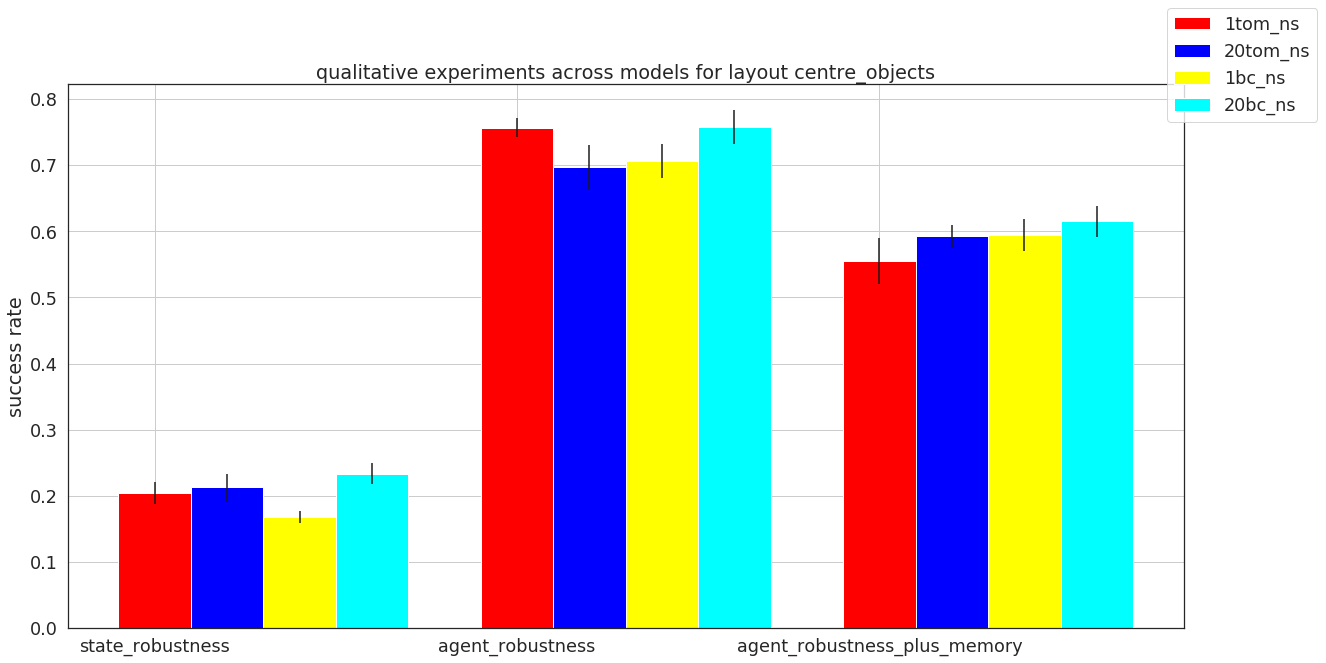

In [15]:
# Or average across all tests of a certain kind, and plot all results on one graph
averaged_by_test_type_results = average_across_different_test_types(results_cobj)
simple_layout_histogram(averaged_by_test_type_results)

In [16]:
# Starts vs no starts

results_20tom_ns = load_pickle("data/qual_results_from_server/results_cobj_20tom_ns.pickle")
results_20tom_s = load_pickle("data/qual_results_from_server/results_cobj_20tom_s.pickle")
results_20mixed_ns = load_pickle("data/qual_results_from_server/results_cobj_20mixed_ns.pickle")
results_20mixed_s = load_pickle("data/qual_results_from_server/results_cobj_20mixed_s.pickle")

# PER-LAYOUT data format
# Standard data format per-layout! Currently assuming that all results in dict are for one specific layout.
results_cobj2 = {
    # Agent name    # Agent results dict as saved by script
    "20tom_ns": results_20tom_ns,
    "20tom_s": results_20tom_s,
    "20mixed_ns": results_20mixed_ns,
    "20mixed_s": results_20mixed_s
}

def colors_fn(agent_name):
    if agent_name == "20tom_ns":
        return "blue"
    elif agent_name == "20tom_s":
        return "cyan"
    elif agent_name == "20mixed_ns":
        return "magenta"
    elif agent_name == "20mixed_s":
        return "green"
    else:
        raise ValueError("Unrecognized agent type {}. Must define a custom color for this agent type".format(agent_name))

Averaging tests with test type state_robustness for agent 20tom_ns
Averaging tests with test type agent_robustness for agent 20tom_ns
Averaging tests with test type agent_robustness_plus_memory for agent 20tom_ns
Averaging tests with test type reward for agent 20tom_ns
Averaging tests with test type state_robustness for agent 20tom_s
Averaging tests with test type agent_robustness for agent 20tom_s
Averaging tests with test type agent_robustness_plus_memory for agent 20tom_s
Averaging tests with test type reward for agent 20tom_s
Averaging tests with test type state_robustness for agent 20mixed_ns
Averaging tests with test type agent_robustness for agent 20mixed_ns
Averaging tests with test type agent_robustness_plus_memory for agent 20mixed_ns
Averaging tests with test type reward for agent 20mixed_ns
Averaging tests with test type state_robustness for agent 20mixed_s
Averaging tests with test type agent_robustness for agent 20mixed_s
Averaging tests with test type agent_robustness_pl

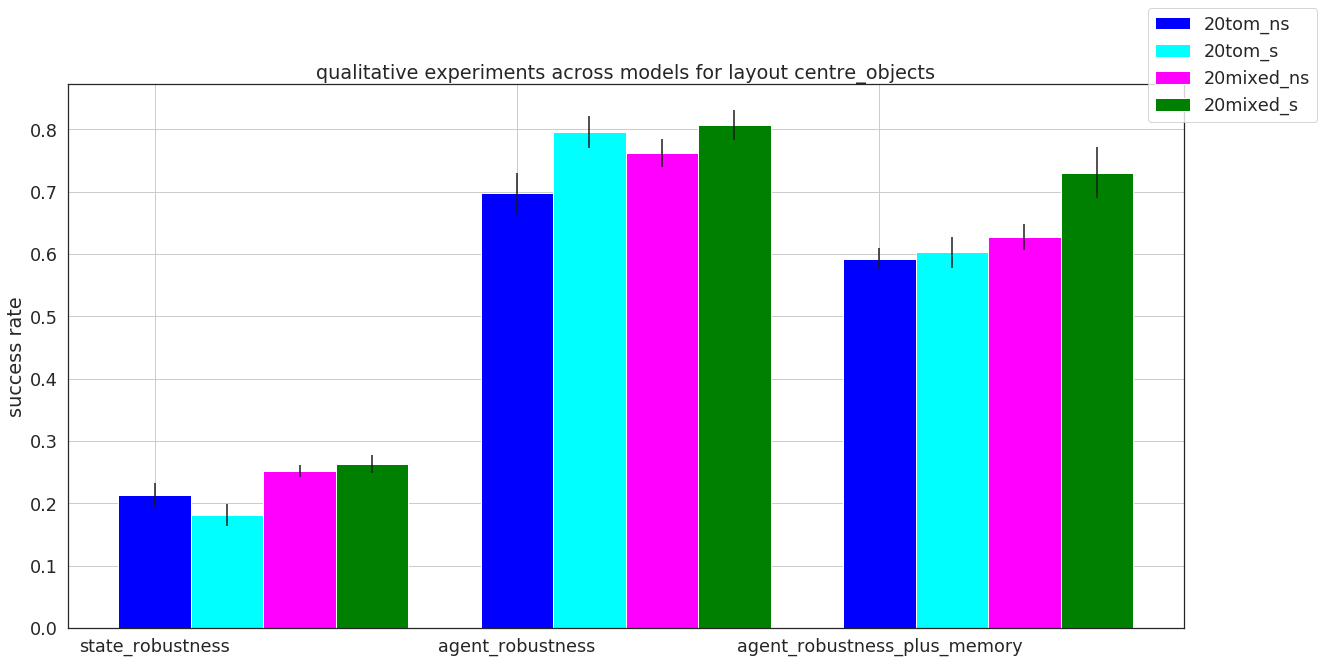

In [18]:
# Or average across all tests of a certain kind, and plot all results on one graph
averaged_by_test_type_results = average_across_different_test_types(results_cobj2)
simple_layout_histogram(averaged_by_test_type_results)

In [20]:
# Different pops WITH data starts

results_1tom_s = load_pickle("data/qual_results_from_server/results_cobj_1tom_s.pickle")
results_5tom_s = load_pickle("data/qual_results_from_server/results_cobj_5tom_s.pickle")
results_20tom_s = load_pickle("data/qual_results_from_server/results_cobj_20tom_s.pickle")
results_20tomrand_s = load_pickle("data/qual_results_from_server/results_cobj_20tomrand_s.pickle")
# results_20mixed_s = load_pickle("data/qual_results_from_server/results_cobj_20mixed_s.pickle")

# PER-LAYOUT data format
# Standard data format per-layout! Currently assuming that all results in dict are for one specific layout.
results_cobj3 = {
    # Agent name    # Agent results dict as saved by script
    "1tom_s": results_1tom_s,
    "5tom_s": results_5tom_s,
    "20tom_s": results_20tom_s,
    "20tomrand_s": results_20tomrand_s,
#     "20mixed_s": results_20mixed_s
}

def colors_fn(agent_name):
    if agent_name == "1tom_s":
        return "red"
    elif agent_name == "5tom_s":
        return "green"
    elif agent_name == "20tom_s":
        return "blue"
    elif agent_name == "20tomrand_s":
        return "yellow"
#     elif agent_name == "20mixed_s":
#         return "cyan"
    else:
        raise ValueError("Unrecognized agent type {}. Must define a custom color for this agent type".format(agent_name))
        

Averaging tests with test type state_robustness for agent 1tom_s
Averaging tests with test type agent_robustness for agent 1tom_s
Averaging tests with test type agent_robustness_plus_memory for agent 1tom_s
Averaging tests with test type reward for agent 1tom_s
Averaging tests with test type state_robustness for agent 5tom_s
Averaging tests with test type agent_robustness for agent 5tom_s
Averaging tests with test type agent_robustness_plus_memory for agent 5tom_s
Averaging tests with test type reward for agent 5tom_s
Averaging tests with test type state_robustness for agent 20tom_s
Averaging tests with test type agent_robustness for agent 20tom_s
Averaging tests with test type agent_robustness_plus_memory for agent 20tom_s
Averaging tests with test type reward for agent 20tom_s
Averaging tests with test type state_robustness for agent 20tomrand_s
Averaging tests with test type agent_robustness for agent 20tomrand_s
Averaging tests with test type agent_robustness_plus_memory for agent 

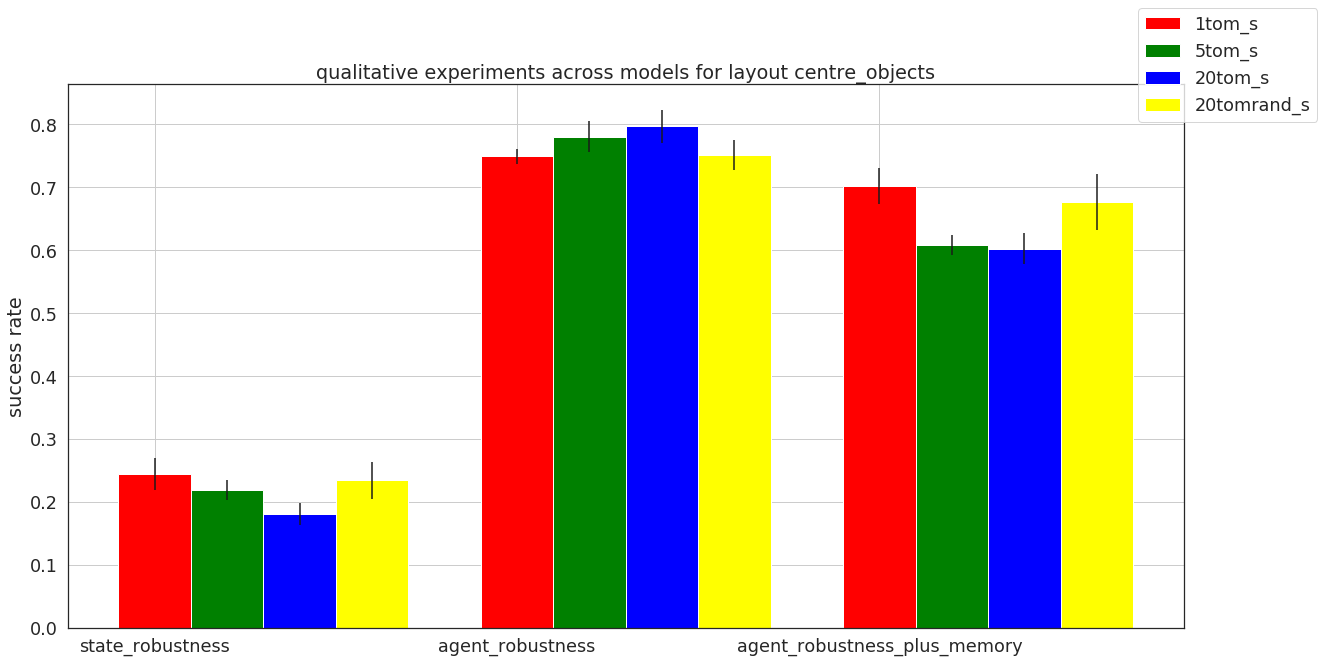

In [22]:
# Or average across all tests of a certain kind, and plot all results on one graph
averaged_by_test_type_results = average_across_different_test_types(results_cobj3)
simple_layout_histogram(averaged_by_test_type_results)

# Paul old Code using wrong data types

In [10]:
# from overcooked_ai_py.utils import load_pickle, mean_and_std_err
# import copy
# import numpy as np
# import matplotlib.pyplot as plt
# from collections import defaultdict
# # from human_ai_robustness.qualitative_robustness_expt import filter_tests_by_attribute, AbstractRobustnessTest
# ALL_TEST_TYPES = ["state_robustness", "agent_robustness", "agent_robustness_plus_memory"] # AbstractRobustnessTest.ALL_TEST_TYPES

In [11]:
# def set_style(font_scale=1.6, tex=True):
#     import seaborn, matplotlib
#     seaborn.set(font='serif', font_scale=font_scale)
#     # Make the background white, and specify the specific font family
#     seaborn.set_style("white", {
#         "font.family": "serif",
#         "font.weight": "normal",
#         "font.serif": ["Times", "Palatino", "serif"],
#         'axes.facecolor': 'white',
#         'lines.markeredgewidth': 1})
#     matplotlib.rcParams['text.usetex'] = tex
#     matplotlib.rc('font',family='serif', serif=['Palatino'])
    
# set_style(tex=False)

In [12]:
# def filter_tests_by_attribute(tests_dict, attribute, value):
#     """
#     Returns tests that have `attribute` == `value`
#     """
#     filtered_tests = {}
#     for test_name, test_data_dict in tests_dict.items():
#         if test_data_dict[attribute] == value:
#             filtered_tests[test_name] = test_data_dict
#     return filtered_tests

# def average_across_tests(tests_dict, avg_name):
#     """
#     Takes in a PER-LAYOUT data format dict and outputs a dict with
#     average success rate (currenlty doesn't do ses).
#     """
#     averaged_test = defaultdict(dict)

#     tests_layout = list(tests_dict.values())[0]['layout']
#     assert all(test['layout'] == tests_layout for test in tests_dict.values())
#     averaged_test_dict = {}
#     # We want to see what the average test score for this type of test (e.g. agent_robustness) is
#     # across seeds, and take the SE w.r.t. to that

#     averaged_test_dict["success_rate_mean_and_se"] = \
#         mean_and_std_err([test["success_rate_mean_and_se"][0] for test in tests_dict.values()])

#     # pk: Changed because the test data is saved in a different format. Previously:
#     #     averaged_test_dict["success_rate_across_seeds"] = np.mean(
#     #         [test["success_rate_across_seeds"] for test in tests_dict.values()], axis=0
#     #     )

#     averaged_test_dict["layout"] = tests_layout
#     return averaged_test_dict


# def average_across_different_test_types(tests_dict):
#     """
#     Takes in a PER-LAYOUT data format dict and outputs a PER-LAYOUT data
#     format dict in which all the tests are replaced with the test types in
#     ALL_TEST_TYPES, and the success rates are averaged across the different
#     tests that compose them
#     """
#     new_tests_dict = defaultdict(lambda: defaultdict(dict))
#     for agent_name, agent_data in tests_dict.items():
#         for test_type in ALL_TEST_TYPES:
#             filtered_tests_dict = filter_tests_by_attribute(agent_data, "test_types", [test_type])
#             new_tests_dict[agent_name][test_type] = average_across_tests(filtered_tests_dict, test_type)
#     return new_tests_dict


# def filter_all_tests_by_attribute(all_test_data, attribute, value):
#     return {agent_name: filter_tests_by_attribute(test_dict, attribute, value) for agent_name, test_dict in
#             all_test_data.items()}


# def simple_layout_histogram(results_dicts, barWidth=0.2):
#     layout = list(list(results_dicts.values())[0].values())[0]['layout']

#     success_means_by_agent = defaultdict(list)
#     success_ses_by_agent = defaultdict(list)

#     for agent_type, result_dict in results_dicts.items():
#         for test_name, test_data in result_dict.items():
#             assert layout == test_data["layout"], "All in same results sub-dict should be from the same layout"
#             # pk Changed because test_data is in a different form:
#             success_mean, success_se = test_data["success_rate_mean_and_se"]
#             success_means_by_agent[agent_type].append(success_mean)
#             success_ses_by_agent[agent_type].append(success_se)

#     x_axis = [k for k, v in list(results_dicts.values())[0].items() if v['layout'] == layout]
#     xs = list(range(len(x_axis)))

#     plt.figure(figsize=(20, 10))
#     for k in results_dicts.keys():
#         xs = np.array(xs) + barWidth
#         ys = success_means_by_agent[k]
#         yerrs = success_ses_by_agent[k]
#         plt.bar(xs, ys, yerr=yerrs, width=barWidth, label=k, alpha=0.8, color=colors_fn(k))
#     plt.title("qualitative experiments across models for layout {}".format(layout))
#     plt.ylabel("success rate")
#     plt.xticks([r + barWidth for r in range(len(xs))], x_axis)
#     plt.grid()
#     plt.legend()
    
# def multi_plot_histograms(results_dicts, layouts, barWidth=0.2):
#     # TODO
#     pass

# def colors_fn(agent_name):
#     if agent_name == "agent_0":
#         return "red"
#     elif agent_name == "agent_1":
#         return "blue"
#     else:
#         raise ValueError("Unrecognized agent type {}. Must define a custom color for this agent type".format(agent_name))

## Testing and example plots  <-- DATA STRUCTURE CHANGED, so these don't work...

In [17]:
# You load results for each agent that you've evaluated independently, and just have to specify the agent's name

# results_a = load_pickle("sample_data")
# results_b = load_pickle("sample_data")

# results_a['Test1ci'] = {'layout': 'coordination_ring',
#   'env_horizon': 15,
#   'test_types': ['agent_robustness'],
#   'num_rollouts_per_initial_state': 1,
#   'trained_agent_type': 'ppo',
#   'agent_run_name': 'lstm_agent_cring_1tom',
#   'success_rate_across_seeds': [0.49, 0.23]
# }
# results_b['Test1ci'] = {'layout': 'coordination_ring',
#   'env_horizon': 15,
#   'test_types': ['agent_robustness'],
#   'num_rollouts_per_initial_state': 1,
#   'trained_agent_type': 'ppo',
#   'agent_run_name': 'lstm_agent_cring_1tom',
#   'success_rate_across_seeds': [0.23, 0.23]
# }

# # PER-LAYOUT data format
# # Standard data format per-layout! Currently assuming that all results in dict are for one specific layout.
# results_cring = {
#     # Agent name    # Agent results dict as saved by script
#     "agent_0":      results_a,
#     "agent_1":      results_b
# }

# # ACROSS-LAYOUT data format
# # Standard data format across-layout
# results_bottleneck = None
# results_across_layouts = {
#     "bottleneck": results_bottleneck,
#     "coordination_ring": results_cring
# }

In [79]:
# Then you can plot a graph for each layout separately which compares the agents
# simple_layout_histogram(results_cring)

In [80]:
# You can do this after filtering for a certain test type, but still having the split by test
# results_filtered = filter_all_tests_by_attribute(results_cring, "test_types", ["state_robustness"])
# simple_layout_histogram(results_filtered)

In [81]:
# Or average across all tests of a certain kind, and plot all results on one graph
# averaged_by_test_type_results = average_across_different_test_types(results_cring)
# simple_layout_histogram(averaged_by_test_type_results)

## Initial results for counter circuit

In [13]:

results_1tom_ns = load_pickle("data/qual_results_from_server/qualitative_expts/results_cc_1tom_ns.pickle")
results_20tom_ns = load_pickle("data/qual_results_from_server/qualitative_expts/results_cc_20tom_ns.pickle")
results_1bc_ns = load_pickle("data/qual_results_from_server/qualitative_expts/results_cc_1bc_ns.pickle")
results_20bc_ns = load_pickle("data/qual_results_from_server/qualitative_expts/results_cc_20bc_ns.pickle")

# PER-LAYOUT data format
# Standard data format per-layout! Currently assuming that all results in dict are for one specific layout.
results_cc = {
    # Agent name    # Agent results dict as saved by script
    "1tom_ns": results_1tom_ns,
    "20tom_ns": results_20tom_ns,
    "1bc_ns": results_1bc_ns,
    "20bc_ns": results_20bc_ns,
}

def colors_fn(agent_name):
    if agent_name == "1tom_ns":
        return "red"
    elif agent_name == "20tom_ns":
        return "blue"
    elif agent_name == "1bc_ns":
        return "yellow"
    elif agent_name == "20bc_ns":
        return "cyan"
    else:
        raise ValueError("Unrecognized agent type {}. Must define a custom color for this agent type".format(agent_name))
        

In [61]:
# Then you can plot a graph for each layout separately which compares the agents
# simple_layout_histogram(results_cring)

In [62]:
# You can do this after filtering for a certain test type, but still having the split by test
# results_filtered = filter_all_tests_by_attribute(results_cring, "test_types", ["state_robustness"])
# simple_layout_histogram(results_filtered)

In [63]:
# You can do this after filtering for a certain test type, but still having the split by test
# results_filtered = filter_all_tests_by_attribute(results_cring, "test_types", ["agent_robustness"])
# simple_layout_histogram(results_filtered)

In [64]:
# You can do this after filtering for a certain test type, but still having the split by test
# results_filtered = filter_all_tests_by_attribute(results_cring, "test_types", ["agent_robustness_plus_memory"])
# simple_layout_histogram(results_filtered)

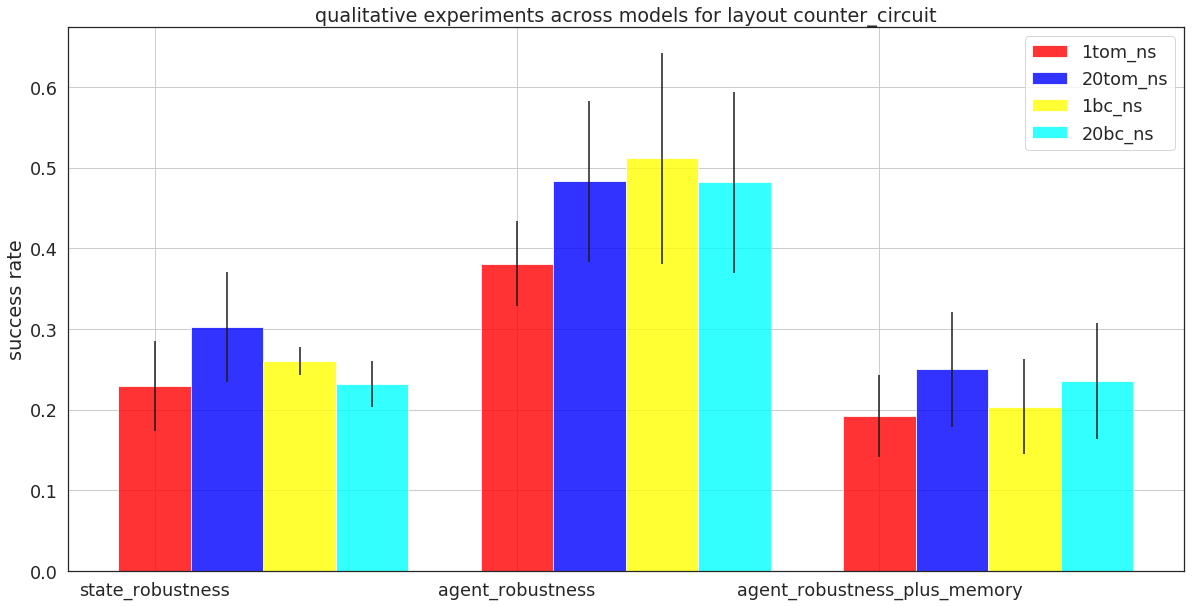

In [14]:
# Or average across all tests of a certain kind, and plot all results on one graph
averaged_by_test_type_results = average_across_different_test_types(results_cc)
simple_layout_histogram(averaged_by_test_type_results)

In [15]:
results_20tom_ns = load_pickle("data/qual_results_from_server/qualitative_expts/results_cc_20tom_ns.pickle")
results_20bc_ns = load_pickle("data/qual_results_from_server/qualitative_expts/results_cc_20bc_ns.pickle")
results_20mixed_ns = load_pickle("data/qual_results_from_server/qualitative_expts/results_cc_20mixed_ns.pickle")
results_20mixed_s = load_pickle("data/qual_results_from_server/qualitative_expts/results_cc_20mixed_s.pickle")

# PER-LAYOUT data format
# Standard data format per-layout! Currently assuming that all results in dict are for one specific layout.
results_cc2 = {
    # Agent name    # Agent results dict as saved by script
    "20tom_ns": results_20tom_ns,
    "20bc_ns": results_20bc_ns,
    "20mixed_ns": results_20mixed_ns,
    "20mixed_s": results_20mixed_s
}

def colors_fn(agent_name):
    if agent_name == "20tom_ns":
        return "blue"
    elif agent_name == "20bc_ns":
        return "cyan"
    elif agent_name == "20mixed_ns":
        return "magenta"
    elif agent_name == "20mixed_s":
        return "green"
    else:
        raise ValueError("Unrecognized agent type {}. Must define a custom color for this agent type".format(agent_name))
        

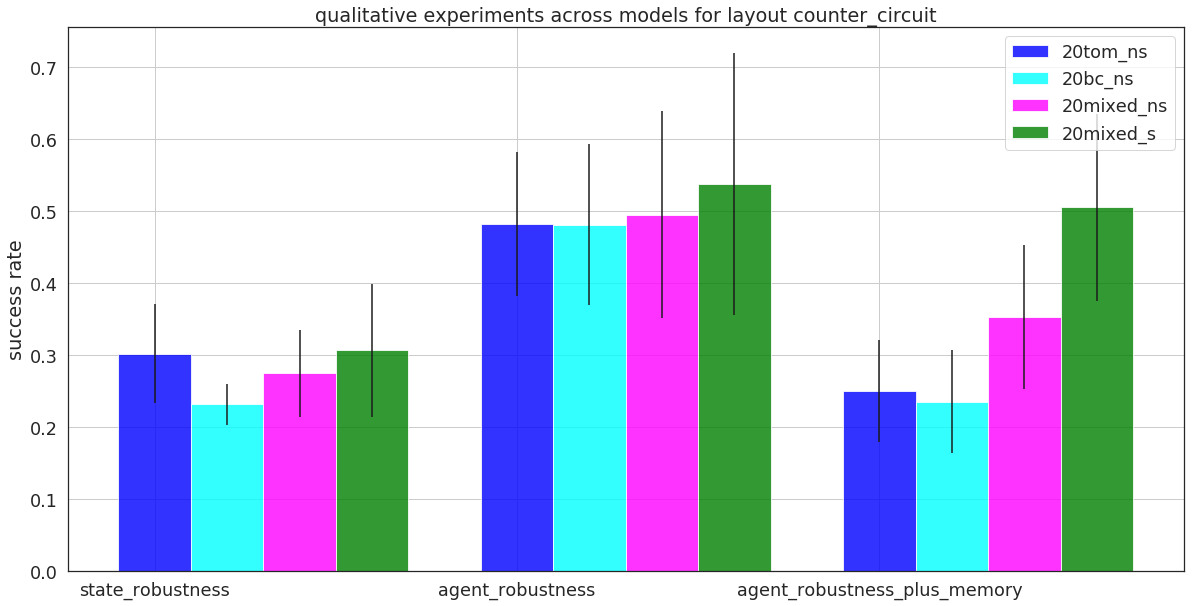

In [93]:
# Or average across all tests of a certain kind, and plot all results on one graph
averaged_by_test_type_results = average_across_different_test_types(results_cc2)
simple_layout_histogram(averaged_by_test_type_results)

## Initial results for coordination ring

In [16]:

results_1tom_ns = load_pickle("data/qual_results_from_server/qualitative_expts/results_cring_1tom_ns.pickle")
results_20tom_ns = load_pickle("data/qual_results_from_server/qualitative_expts/results_cring_20tom_ns.pickle")
results_1bc_ns = load_pickle("data/qual_results_from_server/qualitative_expts/results_cring_1bc_ns.pickle")
results_20bc_ns = load_pickle("data/qual_results_from_server/qualitative_expts/results_cring_20bc_ns.pickle")

# PER-LAYOUT data format
# Standard data format per-layout! Currently assuming that all results in dict are for one specific layout.
results_cring = {
    # Agent name    # Agent results dict as saved by script
    "1tom_ns": results_1tom_ns,
    "20tom_ns": results_20tom_ns,
    "1bc_ns": results_1bc_ns,
    "20bc_ns": results_20bc_ns,
}

def colors_fn(agent_name):
    if agent_name == "1tom_ns":
        return "red"
    elif agent_name == "20tom_ns":
        return "blue"
    elif agent_name == "1bc_ns":
        return "yellow"
    elif agent_name == "20bc_ns":
        return "cyan"
    else:
        raise ValueError("Unrecognized agent type {}. Must define a custom color for this agent type".format(agent_name))
        

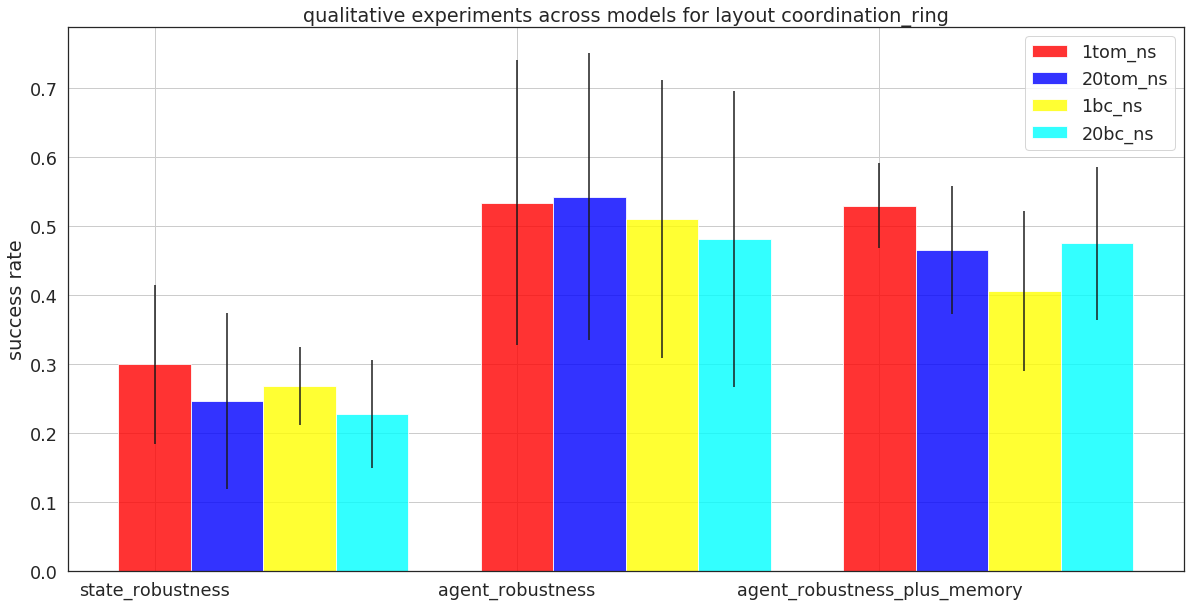

In [17]:
# Or average across all tests of a certain kind, and plot all results on one graph
averaged_by_test_type_results = average_across_different_test_types(results_cring)
simple_layout_histogram(averaged_by_test_type_results)

In [18]:
results_20tom_ns = load_pickle("data/qual_results_from_server/qualitative_expts/results_cring_20tom_ns.pickle")
results_20bc_ns = load_pickle("data/qual_results_from_server/qualitative_expts/results_cring_20bc_ns.pickle")
results_20mixed_ns = load_pickle("data/qual_results_from_server/qualitative_expts/results_cring_20mixed_ns.pickle")
results_20mixed_s = load_pickle("data/qual_results_from_server/qualitative_expts/results_cring_20mixed_s.pickle")

# PER-LAYOUT data format
# Standard data format per-layout! Currently assuming that all results in dict are for one specific layout.
results_cring2 = {
    # Agent name    # Agent results dict as saved by script
    "20tom_ns": results_20tom_ns,
    "20bc_ns": results_20bc_ns,
    "20mixed_ns": results_20mixed_ns,
    "20mixed_s": results_20mixed_s
}

def colors_fn(agent_name):
    if agent_name == "20tom_ns":
        return "blue"
    elif agent_name == "20bc_ns":
        return "cyan"
    elif agent_name == "20mixed_ns":
        return "magenta"
    elif agent_name == "20mixed_s":
        return "green"
    else:
        raise ValueError("Unrecognized agent type {}. Must define a custom color for this agent type".format(agent_name))
        

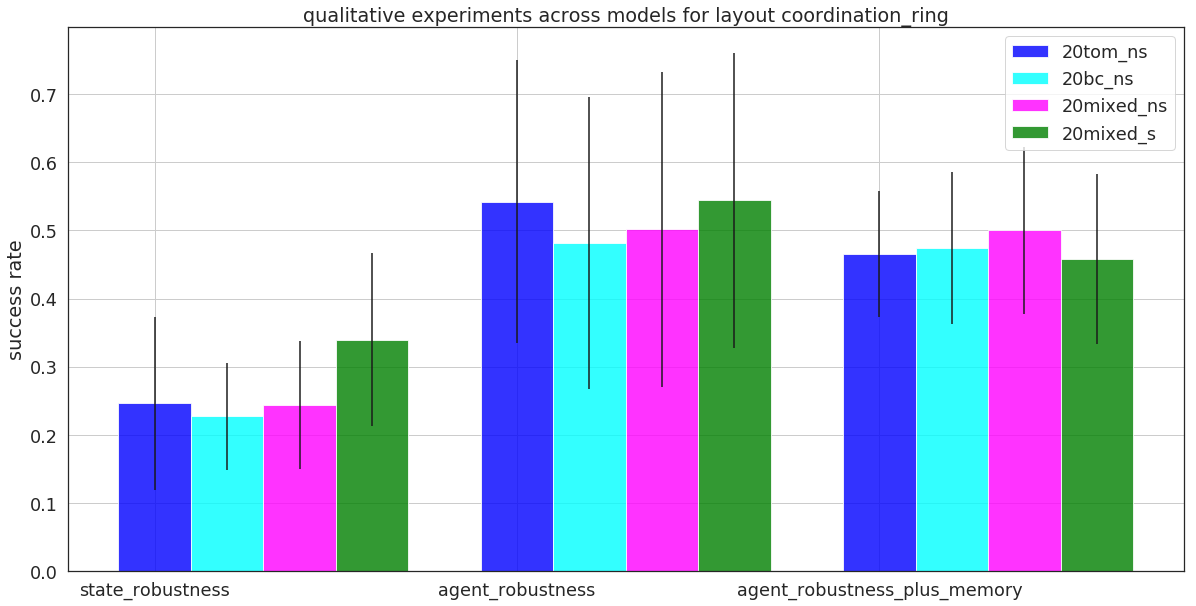

In [19]:
# Or average across all tests of a certain kind, and plot all results on one graph
averaged_by_test_type_results = average_across_different_test_types(results_cring2)
simple_layout_histogram(averaged_by_test_type_results)